<a href="https://colab.research.google.com/github/Owusuk/Projects/blob/main/Final_Project_Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")


# KNN Imputation

from sklearn.impute import KNNImputer


from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures



from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette('Set2')

In [2]:
!pip install xgboost
from xgboost import XGBClassifier

In [3]:
!pip install apyori
from apyori import apriori

In [4]:
#@title TQDM Environment

from tqdm import tqdm
from time import sleep

In [5]:
# Passing TQDM to reduce time for iteration

for i in tqdm(range(10000000)):
    sleep = 0.1
    pass

100%|██████████| 10000000/10000000 [00:01<00:00, 6408850.11it/s]


# Importing & Reading Loan Datasets

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
Loan_Data_df = pd.read_csv("/content/drive/MyDrive/Projects/Project_Final_ETSU/Loan_Data/LC_Loan_Dataset_100K.csv")
Loan_Data_df

Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
0               0  38098114        NaN      15000        15000   
1               1  36805548        NaN      10400        10400   
2               2  37842129        NaN      21425        21425   
3               3  37612354        NaN      12800        12800   
4               4  37662224        NaN       7650         7650   
...           ...       ...        ...        ...          ...   
99995       99995  22454240        NaN       8400         8400   
99996       99996  11396920        NaN      10000        10000   
99997       99997   8556176        NaN      30000        30000   
99998       99998  24023408        NaN       8475         8475   
99999       99999  24023398        NaN      25000        25000   

       funded_amnt_inv        term  int_rate  installment grade  ...  \
0                15000   60 months     12.39       336.64     C  ...   
1                10400   36 months      6.99       321.08     A  ...   
2                21425   60 months     15.59       516.36     D  ...   
3                12800   60 months     17.14       319.08     D  ...   
4                 7650   36 months     13.66       260.20     C  ...   
...                ...         ...       ...          ...   ...  ...   
99995             8400   36 months      9.17       267.79     B  ...   
99996            10000   36 months     12.99       336.90     C  ...   
99997            30000   60 months     20.99       811.44     E  ...   
99998             8475   36 months     24.99       336.92     F  ...   
99999            25000   36 months     10.15       808.45     B  ...   

      hardship_payoff_balance_amount hardship_last_payment_amount  \
0                                NaN                          NaN   
1                                NaN                          NaN   
2                                NaN                          NaN   
3                                NaN                          NaN   
4                                NaN                          NaN   
...                              ...                          ...   
99995                            NaN                          NaN   
99996                            NaN                          NaN   
99997                            NaN                          NaN   
99998                            NaN                          NaN   
99999                            NaN                          NaN   

      disbursement_method debt_settlement_flag  debt_settlement_flag_date  \
0                    Cash                    N                        NaN   
1                    Cash                    N                        NaN   
2                    Cash                    N                        NaN   
3                    Cash                    N                        NaN   
4                    Cash                    N                        NaN   
...                   ...                  ...                        ...   
99995                Cash                    N                        NaN   
99996                Cash                    N                        NaN   
99997                Cash                    N                        NaN   
99998                Cash                    N                        NaN   
99999                Cash                    N                        NaN   

      settlement_status settlement_date settlement_amount  \
0                   NaN             NaN               NaN   
1                   NaN             NaN               NaN   
2                   NaN             NaN               NaN   
3                   NaN             NaN               NaN   
4                   NaN             NaN               NaN   
...                 ...             ...               ...   
99995               NaN             NaN               NaN   
99996               NaN             NaN               NaN   
99997               NaN             NaN       

### Initial Pre-process

In [8]:
Loan_Data_df.drop(columns=["Unnamed: 0", "id", "member_id"], axis=1, inplace=True)
Loan_Data_df

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0          15000        15000            15000   60 months     12.39   
1          10400        10400            10400   36 months      6.99   
2          21425        21425            21425   60 months     15.59   
3          12800        12800            12800   60 months     17.14   
4           7650         7650             7650   36 months     13.66   
...          ...          ...              ...         ...       ...   
99995       8400         8400             8400   36 months      9.17   
99996      10000        10000            10000   36 months     12.99   
99997      30000        30000            30000   60 months     20.99   
99998       8475         8475             8475   36 months     24.99   
99999      25000        25000            25000   36 months     10.15   

       installment grade sub_grade                        emp_title  \
0           336.64     C        C1                       MANAGEMENT   
1           321.08     A        A3   Truck Driver Delivery Personel   
2           516.36     D        D1  Programming Analysis Supervisor   
3           319.08     D        D4        Senior Sales Professional   
4           260.20     C        C3             Technical Specialist   
...            ...   ...       ...                              ...   
99995       267.79     B        B1                Software Engineer   
99996       336.90     C        C1   Assistant Professor of English   
99997       811.44     E        E4                Facilities Tech 3   
99998       336.92     F        F4         Records Examiner Analyst   
99999       808.45     B        B2    Occupational Theapy Assistant   

      emp_length  ... hardship_payoff_balance_amount  \
0      10+ years  ...                            NaN   
1        8 years  ...                            NaN   
2        6 years  ...                            NaN   
3      10+ years  ...                            NaN   
4       < 1 year  ...                            NaN   
...          ...  ...                            ...   
99995    2 years  ...                            NaN   
99996    3 years  ...                            NaN   
99997  10+ years  ...                            NaN   
99998  10+ years  ...                            NaN   
99999    3 years  ...                            NaN   

       hardship_last_payment_amount disbursement_method debt_settlement_flag  \
0                               NaN                Cash                    N   
1                               NaN                Cash                    N   
2                               NaN                Cash                    N   
3                               NaN                Cash                    N   
4                               NaN                Cash                    N   
...                             ...                 ...                  ...   
99995                           NaN                Cash                    N   
99996                           NaN                Cash                    N   
99997                           NaN                Cash                    N   
99998                           NaN                Cash                    N   
99999                           NaN                Cash                    N   

      debt_settlement_flag_date settlement_status settlement_date  \
0                           NaN               NaN             NaN   
1                           NaN               NaN             NaN   
2                           NaN               NaN             NaN   
3                           NaN               NaN             NaN   
4                           NaN               NaN             NaN   
...                         ...               ...             ...   
99995                       NaN               NaN             NaN   
99996                       NaN               NaN             NaN   
99997                       NaN   

### Exploration

In [9]:
# Checking Shape,Data Info, and datatype of loan data

Loan_Data_df.info(verbose=True, show_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 148 columns):
 #    Column                                      Non-Null Count   Dtype  
---   ------                                      --------------   -----  
 0    loan_amnt                                   100000 non-null  int64  
 1    funded_amnt                                 100000 non-null  int64  
 2    funded_amnt_inv                             100000 non-null  int64  
 3    term                                        100000 non-null  object 
 4    int_rate                                    100000 non-null  float64
 5    installment                                 100000 non-null  float64
 6    grade                                       100000 non-null  object 
 7    sub_grade                                   100000 non-null  object 
 8    emp_title                                   94736 non-null   object 
 9    emp_length                                  94741 non-null

In [10]:
# Target (dependent)

print("Uniqule Values for target class:", Loan_Data_df["loan_status"].unique())
print("=======================================================")
print("Count of Values for target variable:", Loan_Data_df["loan_status"].value_counts())

Uniqule Values for target class: ['Fully Paid' 'Charged Off' 'Current' 'Late (31-120 days)'
 'Late (16-30 days)' 'In Grace Period' 'Default']
Count of Values for target variable: loan_status
Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: count, dtype: int64


In [11]:
# Descriptive statistics

Loan_Data_df.describe().round(2)

loan_amnt  funded_amnt  funded_amnt_inv   int_rate  installment  \
count  100000.00    100000.00        100000.00  100000.00    100000.00   
mean    14886.93     14886.93         14883.91      13.28       437.33   
std      8504.43      8504.43          8502.52       4.39       244.32   
min      1000.00      1000.00          1000.00       6.00        30.42   
25%      8000.00      8000.00          8000.00      10.15       261.64   
50%     13050.00     13050.00         13050.00      12.99       380.18   
75%     20000.00     20000.00         20000.00      15.61       573.32   
max     35000.00     35000.00         35000.00      26.06      1408.13   

       annual_inc        dti  delinq_2yrs  fico_range_low  fico_range_high  \
count   100000.00  100000.00    100000.00       100000.00        100000.00   
mean     74689.24      18.77         0.34          692.58           696.58   
std      58095.27       8.54         0.91           29.40            29.40   
min       4000.00       0.00         0.00          660.00           664.00   
25%      45000.00      12.32         0.00          670.00           674.00   
50%      64000.00      18.21         0.00          685.00           689.00   
75%      90000.00      24.76         0.00          705.00           709.00   
max    7500000.00      39.99        22.00          845.00           850.00   

       ...  deferral_term  hardship_amount  hardship_length  hardship_dpd  \
count  ...          185.0           185.00            185.0        185.00   
mean   ...            3.0           110.34              3.0         14.04   
std    ...            0.0            89.27              0.0          9.66   
min    ...            3.0             1.47              3.0          0.00   
25%    ...            3.0            23.76              3.0          7.00   
50%    ...            3.0            96.58              3.0         15.00   
75%    ...            3.0           164.75              3.0         22.00   
max    ...            3.0           382.34              3.0         32.00   

       orig_projected_additional_accrued_interest  \
count                                      152.00   
mean                                       323.50   
std                                        267.63   
min                                          4.41   
25%                                         63.88   
50%                                        281.58   
75%                                        481.49   
max                                       1147.02   

       hardship_payoff_balance_amount  hardship_last_payment_amount  \
count                          185.00                        185.00   
mean                          8046.62                        186.56   
std                           5585.65                        168.55   
min                            174.15                          0.04   
25%                           2465.36                         27.61   
50%                           8049.85                        172.46   
75%                          11968.94                        285.89   
max                          21750.75                        757.42   

       settlement_amount  settlement_percentage  settlement_term  
count            1290.00                1290.00          1290.00  
mean             4768.38                  47.72             8.27  
std              3703.96                   7.05             8.26  
min               233.16                   0.55             0.00  
25%              1951.12                  45.00             0.00  
50%              3881.12                  45.04             6.00  
75%              6503.00                  50.00            14.00  
max             26751.74                 100.00            36.00  

[8 rows x 114 columns]

##Formal Preprocessing

In [12]:
Loan_Data_df

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0          15000        15000            15000   60 months     12.39   
1          10400        10400            10400   36 months      6.99   
2          21425        21425            21425   60 months     15.59   
3          12800        12800            12800   60 months     17.14   
4           7650         7650             7650   36 months     13.66   
...          ...          ...              ...         ...       ...   
99995       8400         8400             8400   36 months      9.17   
99996      10000        10000            10000   36 months     12.99   
99997      30000        30000            30000   60 months     20.99   
99998       8475         8475             8475   36 months     24.99   
99999      25000        25000            25000   36 months     10.15   

       installment grade sub_grade                        emp_title  \
0           336.64     C        C1                       MANAGEMENT   
1           321.08     A        A3   Truck Driver Delivery Personel   
2           516.36     D        D1  Programming Analysis Supervisor   
3           319.08     D        D4        Senior Sales Professional   
4           260.20     C        C3             Technical Specialist   
...            ...   ...       ...                              ...   
99995       267.79     B        B1                Software Engineer   
99996       336.90     C        C1   Assistant Professor of English   
99997       811.44     E        E4                Facilities Tech 3   
99998       336.92     F        F4         Records Examiner Analyst   
99999       808.45     B        B2    Occupational Theapy Assistant   

      emp_length  ... hardship_payoff_balance_amount  \
0      10+ years  ...                            NaN   
1        8 years  ...                            NaN   
2        6 years  ...                            NaN   
3      10+ years  ...                            NaN   
4       < 1 year  ...                            NaN   
...          ...  ...                            ...   
99995    2 years  ...                            NaN   
99996    3 years  ...                            NaN   
99997  10+ years  ...                            NaN   
99998  10+ years  ...                            NaN   
99999    3 years  ...                            NaN   

       hardship_last_payment_amount disbursement_method debt_settlement_flag  \
0                               NaN                Cash                    N   
1                               NaN                Cash                    N   
2                               NaN                Cash                    N   
3                               NaN                Cash                    N   
4                               NaN                Cash                    N   
...                             ...                 ...                  ...   
99995                           NaN                Cash                    N   
99996                           NaN                Cash                    N   
99997                           NaN                Cash                    N   
99998                           NaN                Cash                    N   
99999                           NaN                Cash                    N   

      debt_settlement_flag_date settlement_status settlement_date  \
0                           NaN               NaN             NaN   
1                           NaN               NaN             NaN   
2                           NaN               NaN             NaN   
3                           NaN               NaN             NaN   
4                           NaN               NaN             NaN   
...                         ...               ...             ...   
99995                       NaN               NaN             NaN   
99996                       NaN               NaN             NaN   
99997                       NaN   

In [13]:
# Dropping zip_code

Loan_Data_df2 = Loan_Data_df.drop('zip_code', axis=1)

Loan_Data_df2

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0          15000        15000            15000   60 months     12.39   
1          10400        10400            10400   36 months      6.99   
2          21425        21425            21425   60 months     15.59   
3          12800        12800            12800   60 months     17.14   
4           7650         7650             7650   36 months     13.66   
...          ...          ...              ...         ...       ...   
99995       8400         8400             8400   36 months      9.17   
99996      10000        10000            10000   36 months     12.99   
99997      30000        30000            30000   60 months     20.99   
99998       8475         8475             8475   36 months     24.99   
99999      25000        25000            25000   36 months     10.15   

       installment grade sub_grade                        emp_title  \
0           336.64     C        C1                       MANAGEMENT   
1           321.08     A        A3   Truck Driver Delivery Personel   
2           516.36     D        D1  Programming Analysis Supervisor   
3           319.08     D        D4        Senior Sales Professional   
4           260.20     C        C3             Technical Specialist   
...            ...   ...       ...                              ...   
99995       267.79     B        B1                Software Engineer   
99996       336.90     C        C1   Assistant Professor of English   
99997       811.44     E        E4                Facilities Tech 3   
99998       336.92     F        F4         Records Examiner Analyst   
99999       808.45     B        B2    Occupational Theapy Assistant   

      emp_length  ... hardship_payoff_balance_amount  \
0      10+ years  ...                            NaN   
1        8 years  ...                            NaN   
2        6 years  ...                            NaN   
3      10+ years  ...                            NaN   
4       < 1 year  ...                            NaN   
...          ...  ...                            ...   
99995    2 years  ...                            NaN   
99996    3 years  ...                            NaN   
99997  10+ years  ...                            NaN   
99998  10+ years  ...                            NaN   
99999    3 years  ...                            NaN   

       hardship_last_payment_amount disbursement_method debt_settlement_flag  \
0                               NaN                Cash                    N   
1                               NaN                Cash                    N   
2                               NaN                Cash                    N   
3                               NaN                Cash                    N   
4                               NaN                Cash                    N   
...                             ...                 ...                  ...   
99995                           NaN                Cash                    N   
99996                           NaN                Cash                    N   
99997                           NaN                Cash                    N   
99998                           NaN                Cash                    N   
99999                           NaN                Cash                    N   

      debt_settlement_flag_date settlement_status settlement_date  \
0                           NaN               NaN             NaN   
1                           NaN               NaN             NaN   
2                           NaN               NaN             NaN   
3                           NaN               NaN             NaN   
4                           NaN               NaN             NaN   
...                         ...               ...             ...   
99995                       NaN               NaN             NaN   
99996                       NaN               NaN             NaN   
99997                       NaN   

##**Detecting Missing Values**

In [14]:
Loan_Data_df2.isna()

loan_amnt  funded_amnt  funded_amnt_inv   term  int_rate  installment  \
0          False        False            False  False     False        False   
1          False        False            False  False     False        False   
2          False        False            False  False     False        False   
3          False        False            False  False     False        False   
4          False        False            False  False     False        False   
...          ...          ...              ...    ...       ...          ...   
99995      False        False            False  False     False        False   
99996      False        False            False  False     False        False   
99997      False        False            False  False     False        False   
99998      False        False            False  False     False        False   
99999      False        False            False  False     False        False   

       grade  sub_grade  emp_title  emp_length  ...  \
0      False      False      False       False  ...   
1      False      False      False       False  ...   
2      False      False      False       False  ...   
3      False      False      False       False  ...   
4      False      False      False       False  ...   
...      ...        ...        ...         ...  ...   
99995  False      False      False       False  ...   
99996  False      False      False       False  ...   
99997  False      False      False       False  ...   
99998  False      False      False       False  ...   
99999  False      False      False       False  ...   

       hardship_payoff_balance_amount  hardship_last_payment_amount  \
0                                True                          True   
1                                True                          True   
2                                True                          True   
3                                True                          True   
4                                True                          True   
...                               ...                           ...   
99995                            True                          True   
99996                            True                          True   
99997                            True                          True   
99998                            True                          True   
99999                            True                          True   

       disbursement_method  debt_settlement_flag  debt_settlement_flag_date  \
0                    False                 False                       True   
1                    False                 False                       True   
2                    False                 False                       True   
3                    False                 False                       True   
4                    False                 False                       True   
...                    ...                   ...                        ...   
99995                False                 False                       True   
99996                False                 False                       True   
99997                False                 False                       True   
99998                False                 False                       True   
99999                False                 False                       True   

       settlement_status  settlement_date  settlement_amount  \
0                   True             True               True   
1                   True             True               True   
2                   True             True               True   
3                   True             True               True   
4                   True             True               True   
...                  ...              ...                ...   
99995               True             True               True   
99996               True             True               True   
99997  

In [15]:
# Showing all Features with NA's in percentages

for cols in Loan_Data_df2.columns:
    percentage_of_missing = np.mean(Loan_Data_df2[cols].isnull())
    print('{} - {}%'.format(cols, round(percentage_of_missing*100)))

loan_amnt - 0%
funded_amnt - 0%
funded_amnt_inv - 0%
term - 0%
int_rate - 0%
installment - 0%
grade - 0%
sub_grade - 0%
emp_title - 5%
emp_length - 5%
home_ownership - 0%
annual_inc - 0%
verification_status - 0%
issue_d - 0%
loan_status - 0%
pymnt_plan - 0%
desc - 100%
purpose - 0%
title - 0%
addr_state - 0%
dti - 0%
delinq_2yrs - 0%
earliest_cr_line - 0%
fico_range_low - 0%
fico_range_high - 0%
inq_last_6mths - 0%
mths_since_last_delinq - 49%
mths_since_last_record - 83%
open_acc - 0%
pub_rec - 0%
revol_bal - 0%
revol_util - 0%
total_acc - 0%
initial_list_status - 0%
out_prncp - 0%
out_prncp_inv - 0%
total_pymnt - 0%
total_pymnt_inv - 0%
total_rec_prncp - 0%
total_rec_int - 0%
total_rec_late_fee - 0%
recoveries - 0%
collection_recovery_fee - 0%
last_pymnt_d - 0%
last_pymnt_amnt - 0%
next_pymnt_d - 86%
last_credit_pull_d - 0%
last_fico_range_high - 0%
last_fico_range_low - 0%
collections_12_mths_ex_med - 0%
mths_since_last_major_derog - 72%
policy_code - 0%
application_type - 0%
annual

Text(0.5, 1.0, 'Missing Data Pattern')

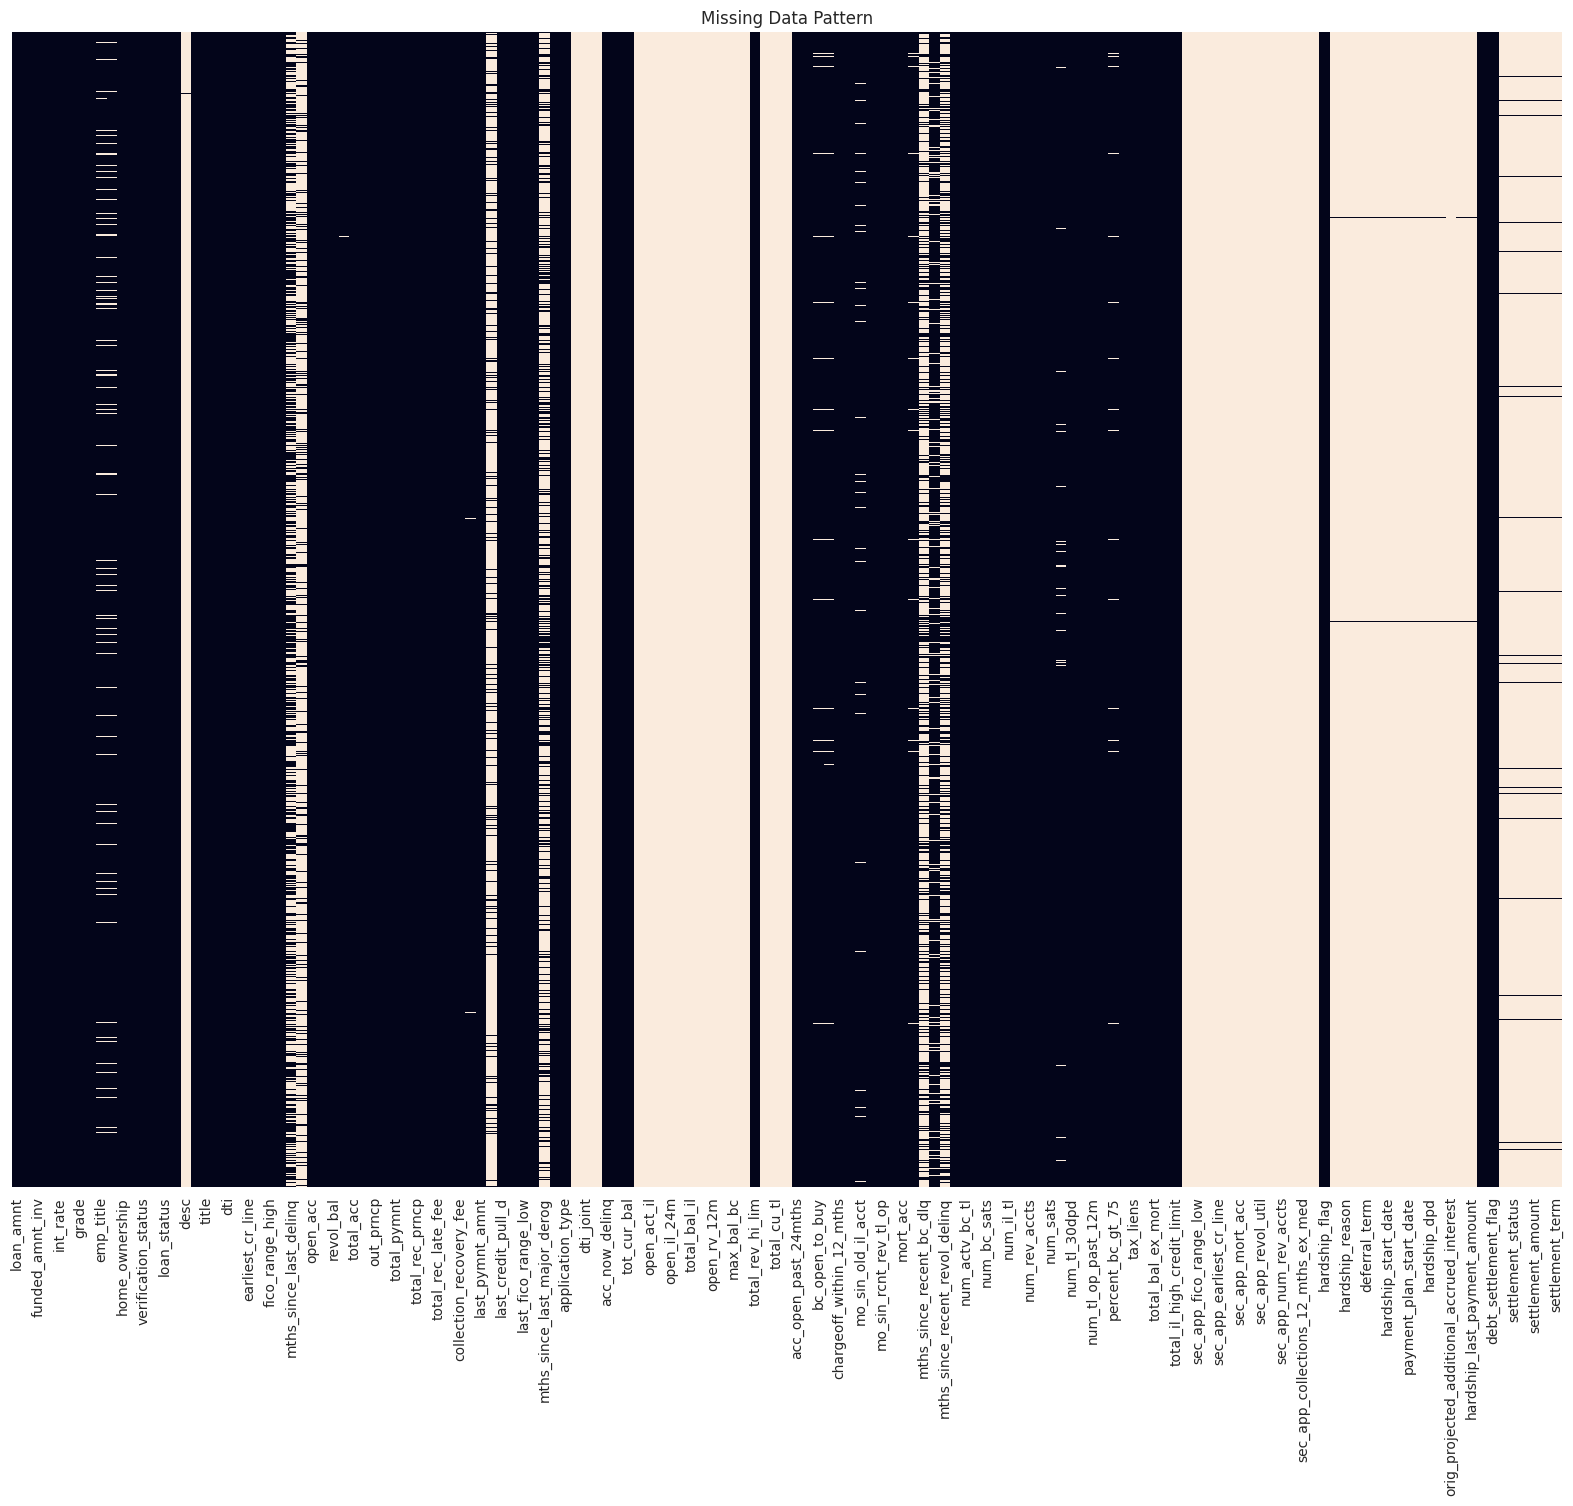

In [16]:
plt.figure(figsize=(20, 15))
sns.heatmap(Loan_Data_df2.isnull(), yticklabels=False, cbar=False)
plt.title('Missing Data Pattern')

In [17]:
Loan_Data_df2.shape

(100000, 147)

In [18]:
# Dropping NAs beyond 40%

for cols in Loan_Data_df2.columns:
    percentage_of_missing = np.mean(Loan_Data_df2[cols].isnull())
    if percentage_of_missing >= 0.4:
        Loan_Data_df2.drop(cols, axis=1, inplace=True)
Loan_Data_df2

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0          15000        15000            15000   60 months     12.39   
1          10400        10400            10400   36 months      6.99   
2          21425        21425            21425   60 months     15.59   
3          12800        12800            12800   60 months     17.14   
4           7650         7650             7650   36 months     13.66   
...          ...          ...              ...         ...       ...   
99995       8400         8400             8400   36 months      9.17   
99996      10000        10000            10000   36 months     12.99   
99997      30000        30000            30000   60 months     20.99   
99998       8475         8475             8475   36 months     24.99   
99999      25000        25000            25000   36 months     10.15   

       installment grade sub_grade                        emp_title  \
0           336.64     C        C1                       MANAGEMENT   
1           321.08     A        A3   Truck Driver Delivery Personel   
2           516.36     D        D1  Programming Analysis Supervisor   
3           319.08     D        D4        Senior Sales Professional   
4           260.20     C        C3             Technical Specialist   
...            ...   ...       ...                              ...   
99995       267.79     B        B1                Software Engineer   
99996       336.90     C        C1   Assistant Professor of English   
99997       811.44     E        E4                Facilities Tech 3   
99998       336.92     F        F4         Records Examiner Analyst   
99999       808.45     B        B2    Occupational Theapy Assistant   

      emp_length  ... percent_bc_gt_75  pub_rec_bankruptcies tax_liens  \
0      10+ years  ...              0.0                     0         0   
1        8 years  ...             14.3                     0         0   
2        6 years  ...            100.0                     0         0   
3      10+ years  ...            100.0                     0         0   
4       < 1 year  ...            100.0                     0         0   
...          ...  ...              ...                   ...       ...   
99995    2 years  ...             50.0                     0         0   
99996    3 years  ...             11.1                     0         0   
99997  10+ years  ...            100.0                     0         0   
99998  10+ years  ...            100.0                     1         0   
99999    3 years  ...             40.0                     0         0   

      tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0              196500            149140          10000   
1              179407             15030          13000   
2               57073             42315          15000   
3              368700             18007           4400   
4               82331             64426           4900   
...               ...               ...            ...   
99995          209557             20872          11000   
99996           64149             46413          24300   
99997          371088             45447          22300   
99998           43686             31247           2700   
99999          290888             71301          40300   

      total_il_high_credit_limit hardship_flag disbursement_method  \
0                          12000             N                Cash   
1                          11325             N                Cash   
2                          35573             N                Cash   
3                          18000             N                Cash   
4                          64031             N                Cash   
...                          ...           ...                 ...   
99995                      15473             N                Cash   
99996                      39849             N                Cash   
99997                      25212             N                Cash   
999

In [19]:
Loan_Data_df2.shape

(100000, 90)

## Assessing duplicates for both rows and columns (Future Selection) with Variance and Pearson Correlation

In [20]:
# Using Variance and Pearson Correlation

numeric_cols = Loan_Data_df2.select_dtypes(include=["int64", "float64"]).columns.tolist()

variance = Loan_Data_df2[numeric_cols].var().round(2)
corr_coef = Loan_Data_df2[numeric_cols].corr().round(2)

# Check if any variance is less than 0.2 and if any absolute correlation coefficient is greater than 0.85

if (variance < 0.2).any(axis=None) and (abs(corr_coef) > 0.85).any(axis=None):
    print('Duplicates likely present in the dataset')
else:
    print('No duplicates detected')

Duplicates likely present in the dataset


In [21]:
# Identify duplicate rows

duplicates = Loan_Data_df2[Loan_Data_df2.duplicated(subset=numeric_cols, keep=False)]

# Print the duplicate rows

print("Duplicate rows:")
print(duplicates)

# Create a new dataframe with duplicates removed

Loan_Data_df3 = Loan_Data_df2.drop_duplicates(subset=numeric_cols, keep='first')

print("Dataset after removing duplicates:")
Loan_Data_df3

Duplicate rows:
Empty DataFrame
Columns: [loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, purpose, title, addr_state, dti, delinq_2yrs, earliest_cr_line, fico_range_low, fico_range_high, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, last_fico_range_high, last_fico_range_low, collections_12_mths_ex_med, policy_code, application_type, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim, acc_open_past_24mths, avg_cur_bal, bc_open_to_buy, bc_util, chargeoff_within_12_mths, delinq_amnt, mo_sin_old_il_acct, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, mths_s

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0          15000        15000            15000   60 months     12.39   
1          10400        10400            10400   36 months      6.99   
2          21425        21425            21425   60 months     15.59   
3          12800        12800            12800   60 months     17.14   
4           7650         7650             7650   36 months     13.66   
...          ...          ...              ...         ...       ...   
99995       8400         8400             8400   36 months      9.17   
99996      10000        10000            10000   36 months     12.99   
99997      30000        30000            30000   60 months     20.99   
99998       8475         8475             8475   36 months     24.99   
99999      25000        25000            25000   36 months     10.15   

       installment grade sub_grade                        emp_title  \
0           336.64     C        C1                       MANAGEMENT   
1           321.08     A        A3   Truck Driver Delivery Personel   
2           516.36     D        D1  Programming Analysis Supervisor   
3           319.08     D        D4        Senior Sales Professional   
4           260.20     C        C3             Technical Specialist   
...            ...   ...       ...                              ...   
99995       267.79     B        B1                Software Engineer   
99996       336.90     C        C1   Assistant Professor of English   
99997       811.44     E        E4                Facilities Tech 3   
99998       336.92     F        F4         Records Examiner Analyst   
99999       808.45     B        B2    Occupational Theapy Assistant   

      emp_length  ... percent_bc_gt_75  pub_rec_bankruptcies tax_liens  \
0      10+ years  ...              0.0                     0         0   
1        8 years  ...             14.3                     0         0   
2        6 years  ...            100.0                     0         0   
3      10+ years  ...            100.0                     0         0   
4       < 1 year  ...            100.0                     0         0   
...          ...  ...              ...                   ...       ...   
99995    2 years  ...             50.0                     0         0   
99996    3 years  ...             11.1                     0         0   
99997  10+ years  ...            100.0                     0         0   
99998  10+ years  ...            100.0                     1         0   
99999    3 years  ...             40.0                     0         0   

      tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0              196500            149140          10000   
1              179407             15030          13000   
2               57073             42315          15000   
3              368700             18007           4400   
4               82331             64426           4900   
...               ...               ...            ...   
99995          209557             20872          11000   
99996           64149             46413          24300   
99997          371088             45447          22300   
99998           43686             31247           2700   
99999          290888             71301          40300   

      total_il_high_credit_limit hardship_flag disbursement_method  \
0                          12000             N                Cash   
1                          11325             N                Cash   
2                          35573             N                Cash   
3                          18000             N                Cash   
4                          64031             N                Cash   
...                          ...           ...                 ...   
99995                      15473             N                Cash   
99996                      39849             N                Cash   
99997                      25212             N                Cash   
999

In [22]:
# Drop columns with high correlation (above 0.85)

high_corr_cols = [(i, j) for i in range(len(corr_coef.columns)) for j in range(i) if abs(corr_coef.iloc[i, j]) > 0.85]

cols_to_drop_corr = [corr_coef.columns[i] for i, j in high_corr_cols]

# Drop columns with low variance (below 0.2)

low_var_cols = [col for col in numeric_cols if variance[col] < 0.2]

# Combine the columns to drop

cols_to_drop = cols_to_drop_corr + low_var_cols

# Drop the columns

Loan_Data_df3.drop(cols_to_drop, axis=1, inplace=True)

print("Dataset after dropping correlated and low-variance columns:")

Loan_Data_df3

Dataset after dropping correlated and low-variance columns:


loan_amnt        term  int_rate grade sub_grade  \
0          15000   60 months     12.39     C        C1   
1          10400   36 months      6.99     A        A3   
2          21425   60 months     15.59     D        D1   
3          12800   60 months     17.14     D        D4   
4           7650   36 months     13.66     C        C3   
...          ...         ...       ...   ...       ...   
99995       8400   36 months      9.17     B        B1   
99996      10000   36 months     12.99     C        C1   
99997      30000   60 months     20.99     E        E4   
99998       8475   36 months     24.99     F        F4   
99999      25000   36 months     10.15     B        B2   

                             emp_title emp_length home_ownership  annual_inc  \
0                           MANAGEMENT  10+ years           RENT     78000.0   
1       Truck Driver Delivery Personel    8 years       MORTGAGE     58000.0   
2      Programming Analysis Supervisor    6 years           RENT     63800.0   
3            Senior Sales Professional  10+ years       MORTGAGE    125000.0   
4                 Technical Specialist   < 1 year           RENT     50000.0   
...                                ...        ...            ...         ...   
99995                Software Engineer    2 years       MORTGAGE     91000.0   
99996   Assistant Professor of English    3 years           RENT     53133.0   
99997                Facilities Tech 3  10+ years           RENT     78000.0   
99998         Records Examiner Analyst  10+ years           RENT     52000.0   
99999    Occupational Theapy Assistant    3 years            OWN     60000.0   

      verification_status  ... num_tl_90g_dpd_24m num_tl_op_past_12m  \
0         Source Verified  ...                  0                  4   
1            Not Verified  ...                  0                  4   
2         Source Verified  ...                  0                  2   
3                Verified  ...                  0                  0   
4         Source Verified  ...                  0                  2   
...                   ...  ...                ...                ...   
99995     Source Verified  ...                  0                  2   
99996        Not Verified  ...                  0                  1   
99997            Verified  ...                  0                  4   
99998            Verified  ...                  1                  6   
99999     Source Verified  ...                  0                  3   

      pct_tl_nvr_dlq percent_bc_gt_75 total_bal_ex_mort total_bc_limit  \
0              100.0              0.0            149140          10000   
1               83.3             14.3             15030          13000   
2               91.4            100.0             42315          15000   
3               76.9            100.0             18007           4400   
4              100.0            100.0             64426           4900   
...              ...              ...               ...            ...   
99995           93.7             50.0             20872          11000   
99996          100.0             11.1             46413          24300   
99997           93.3            100.0             45447          22300   
99998           86.4            100.0             31247           2700   
99999          100.0             40.0             71301          40300   

       total_il_high_credit_limit  hardship_flag disbursement_method  \
0                           12000              N                Cash   
1                           11325              N                Cash   
2                           35573              N                Cash   
3                           18000              N                Cash   
4                           64031              N                Cash   
...                           ...            ...                 ...   
99995                       15473              N                Cash   
99996              

In [23]:
Loan_Data_df3.shape

(100000, 70)

In [24]:
Loan_Data_df3.duplicated().any()

False

In [25]:
# Checking further Features with NA's in percentages

for cols in Loan_Data_df3.columns:
    percentage_of_missing = np.mean(Loan_Data_df3[cols].isnull())
    print('{} - {}%'.format(cols, round(percentage_of_missing*100)))

loan_amnt - 0%
term - 0%
int_rate - 0%
grade - 0%
sub_grade - 0%
emp_title - 5%
emp_length - 5%
home_ownership - 0%
annual_inc - 0%
verification_status - 0%
issue_d - 0%
loan_status - 0%
pymnt_plan - 0%
purpose - 0%
title - 0%
addr_state - 0%
dti - 0%
delinq_2yrs - 0%
earliest_cr_line - 0%
fico_range_low - 0%
inq_last_6mths - 0%
open_acc - 0%
pub_rec - 0%
revol_bal - 0%
revol_util - 0%
total_acc - 0%
initial_list_status - 0%
out_prncp - 0%
total_rec_int - 0%
total_rec_late_fee - 0%
recoveries - 0%
last_pymnt_d - 0%
last_pymnt_amnt - 0%
last_credit_pull_d - 0%
last_fico_range_high - 0%
last_fico_range_low - 0%
application_type - 0%
tot_coll_amt - 0%
tot_cur_bal - 0%
total_rev_hi_lim - 0%
acc_open_past_24mths - 0%
avg_cur_bal - 0%
bc_open_to_buy - 1%
bc_util - 1%
delinq_amnt - 0%
mo_sin_old_il_acct - 3%
mo_sin_old_rev_tl_op - 0%
mo_sin_rcnt_rev_tl_op - 0%
mo_sin_rcnt_tl - 0%
mort_acc - 0%
mths_since_recent_bc - 1%
mths_since_recent_inq - 10%
num_accts_ever_120_pd - 0%
num_actv_bc_tl - 0%

In [26]:
Loan_Data_df3.info(verbose=True, show_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 70 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   100000 non-null  int64  
 1   term                        100000 non-null  object 
 2   int_rate                    100000 non-null  float64
 3   grade                       100000 non-null  object 
 4   sub_grade                   100000 non-null  object 
 5   emp_title                   94736 non-null   object 
 6   emp_length                  94741 non-null   object 
 7   home_ownership              100000 non-null  object 
 8   annual_inc                  100000 non-null  float64
 9   verification_status         100000 non-null  object 
 10  issue_d                     100000 non-null  object 
 11  loan_status                 100000 non-null  object 
 12  pymnt_plan                  100000 non-null  object 
 13  purpose        

In [27]:
# Unique Values of Columns

for cols in Loan_Data_df3.columns:
    print(cols, Loan_Data_df3[cols].unique())

loan_amnt [15000 10400 21425 ... 30975 29875 30475]
term [' 60 months' ' 36 months']
int_rate [12.39  6.99 15.59 17.14 13.66 11.99 11.44 14.31 17.86 21.99 10.49 14.99
 15.99 19.99 12.99  9.49 20.99  7.49 16.49  8.67  8.19 22.99 18.54 19.24
 25.83 25.8  24.5  23.99  6.03  6.49 25.89 24.99  6.   25.99 25.57 26.06
 17.57 14.49 13.98 12.49 16.29 10.15  8.39 23.43 15.61 18.24  9.17 16.99
  7.69 10.99 20.2  19.52 11.67 13.35 22.15 18.99  7.12 24.08]
grade ['C' 'A' 'D' 'B' 'E' 'F' 'G']
sub_grade ['C1' 'A3' 'D1' 'D4' 'C3' 'B5' 'B4' 'C4' 'D5' 'E5' 'B3' 'C5' 'D2' 'E3'
 'C2' 'B2' 'E4' 'A4' 'D3' 'B1' 'A5' 'F1' 'E1' 'E2' 'G2' 'G1' 'F3' 'F2'
 'A1' 'A2' 'G3' 'F4' 'G4' 'F5' 'G5']
emp_title ['MANAGEMENT' 'Truck Driver Delivery Personel'
 'Programming Analysis Supervisor' ... 'Facilities Tech 3'
 'Records Examiner Analyst' 'Occupational Theapy Assistant']
emp_length ['10+ years' '8 years' '6 years' '< 1 year' '2 years' '9 years' '7 years'
 '5 years' '3 years' '1 year' nan '4 years']
home_ownership ['REN

In [28]:
#@title Histogram for home_ownership

fig = px.histogram(Loan_Data_df3, x="home_ownership", title="Histogram of Home Ownership")
fig.show()

In [29]:
# Deleting ANY from home_ownership

Loan_Data_df3 = Loan_Data_df3[Loan_Data_df3['home_ownership'] != 'ANY']

In [30]:
Loan_Data_df3.shape

(99999, 70)

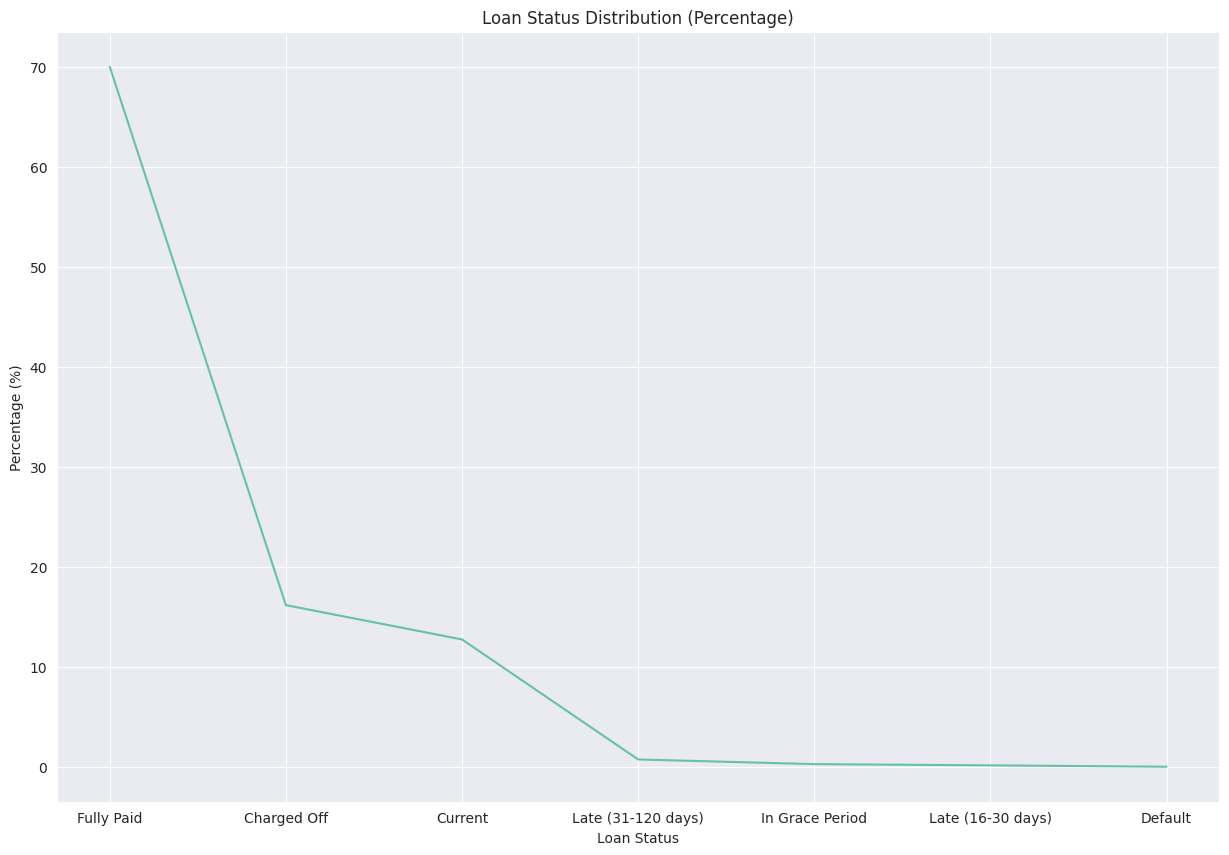

In [31]:
# Calculate the percentage distribution of loan status

loan_status_percentage = Loan_Data_df3['loan_status'].value_counts(normalize=True) * 100

plt.figure(figsize=(15, 10))
loan_status_percentage.plot(kind='line')
plt.title('Loan Status Distribution (Percentage)')
plt.xlabel('Loan Status')
plt.ylabel('Percentage (%)')
plt.grid(True)
plt.show()

### *Setting the assumption to consider only loan that is fully paid, charged off, and current due to their proportions*

In [32]:
Loan_Data_df3['loan_status'].value_counts()

loan_status
Fully Paid            69981
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: count, dtype: int64

In [33]:
# Names of indexes for which feature 'loan_status' is not 'Fully Paid' or 'Charged off' or 'Current' (Cleaning irrelevant values)

index_names = Loan_Data_df3[(Loan_Data_df3['loan_status'] != 'Fully Paid') & (Loan_Data_df3['loan_status'] !='Charged Off') & (Loan_Data_df3['loan_status'] !='Current')].index

In [34]:
# Dropping the row indexes from the dataset

Loan_Data_df3.drop(index_names, inplace = True)
Loan_Data_df3

loan_amnt        term  int_rate grade sub_grade  \
0          15000   60 months     12.39     C        C1   
1          10400   36 months      6.99     A        A3   
2          21425   60 months     15.59     D        D1   
3          12800   60 months     17.14     D        D4   
4           7650   36 months     13.66     C        C3   
...          ...         ...       ...   ...       ...   
99995       8400   36 months      9.17     B        B1   
99996      10000   36 months     12.99     C        C1   
99997      30000   60 months     20.99     E        E4   
99998       8475   36 months     24.99     F        F4   
99999      25000   36 months     10.15     B        B2   

                             emp_title emp_length home_ownership  annual_inc  \
0                           MANAGEMENT  10+ years           RENT     78000.0   
1       Truck Driver Delivery Personel    8 years       MORTGAGE     58000.0   
2      Programming Analysis Supervisor    6 years           RENT     63800.0   
3            Senior Sales Professional  10+ years       MORTGAGE    125000.0   
4                 Technical Specialist   < 1 year           RENT     50000.0   
...                                ...        ...            ...         ...   
99995                Software Engineer    2 years       MORTGAGE     91000.0   
99996   Assistant Professor of English    3 years           RENT     53133.0   
99997                Facilities Tech 3  10+ years           RENT     78000.0   
99998         Records Examiner Analyst  10+ years           RENT     52000.0   
99999    Occupational Theapy Assistant    3 years            OWN     60000.0   

      verification_status  ... num_tl_90g_dpd_24m num_tl_op_past_12m  \
0         Source Verified  ...                  0                  4   
1            Not Verified  ...                  0                  4   
2         Source Verified  ...                  0                  2   
3                Verified  ...                  0                  0   
4         Source Verified  ...                  0                  2   
...                   ...  ...                ...                ...   
99995     Source Verified  ...                  0                  2   
99996        Not Verified  ...                  0                  1   
99997            Verified  ...                  0                  4   
99998            Verified  ...                  1                  6   
99999     Source Verified  ...                  0                  3   

      pct_tl_nvr_dlq percent_bc_gt_75 total_bal_ex_mort total_bc_limit  \
0              100.0              0.0            149140          10000   
1               83.3             14.3             15030          13000   
2               91.4            100.0             42315          15000   
3               76.9            100.0             18007           4400   
4              100.0            100.0             64426           4900   
...              ...              ...               ...            ...   
99995           93.7             50.0             20872          11000   
99996          100.0             11.1             46413          24300   
99997           93.3            100.0             45447          22300   
99998           86.4            100.0             31247           2700   
99999          100.0             40.0             71301          40300   

       total_il_high_credit_limit  hardship_flag disbursement_method  \
0                           12000              N                Cash   
1                           11325              N                Cash   
2                           35573              N                Cash   
3                           18000              N                Cash   
4                           64031              N                Cash   
...                           ...            ...                 ...   
99995                       15473              N                Cash   
99996              

In [35]:
Loan_Data_df3['loan_status'].value_counts()

loan_status
Fully Paid     69981
Charged Off    16156
Current        12726
Name: count, dtype: int64

In [36]:
Loan_Data_df3.shape

(98863, 70)

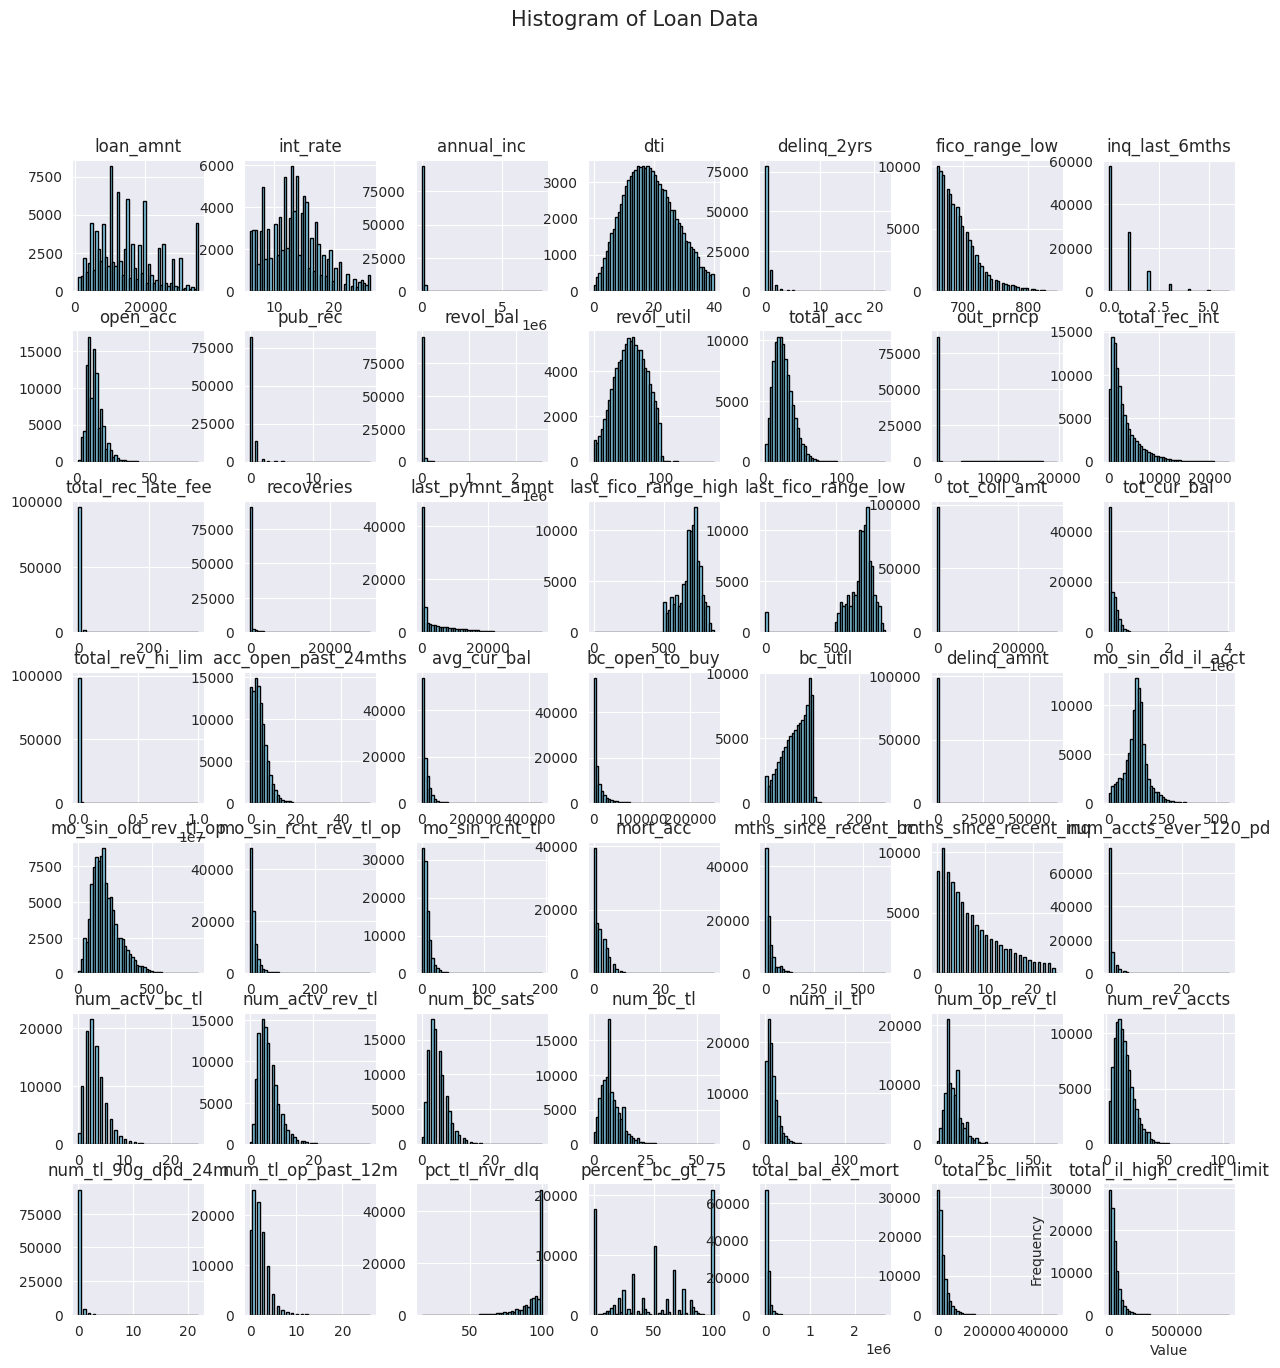

In [37]:
# Histogram plot

Loan_Data_df3.hist(bins=50, figsize=(15, 15), color='skyblue', edgecolor='black')

# Adding titles and labels
plt.suptitle('Histogram of Loan Data', fontsize=15)
plt.xlabel('Value', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Show the plot
plt.show()

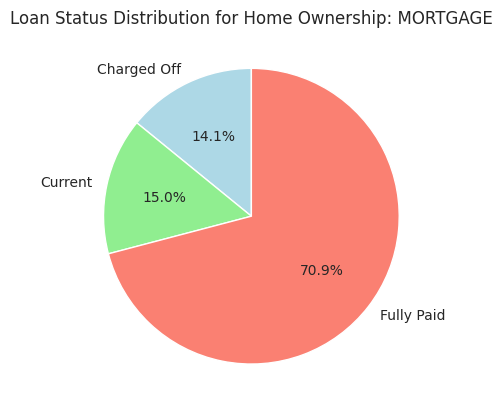

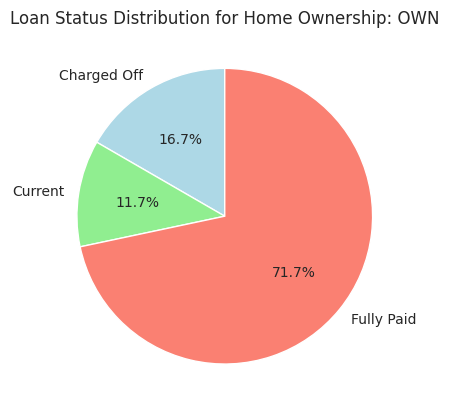

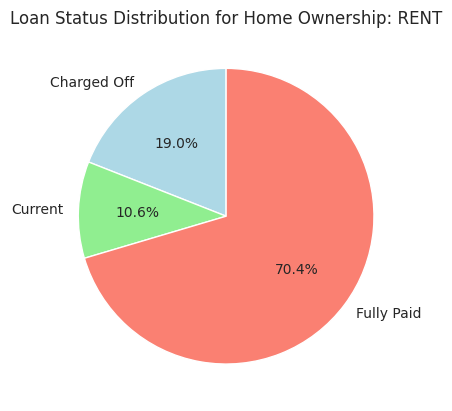

In [38]:
# Distribution between home_ownership and loan_status

home_ownership_distribution = Loan_Data_df3.groupby('home_ownership')['loan_status'].value_counts().unstack()

# Create a pie chart for each home ownership type

for ownership_type in home_ownership_distribution.index:
    plt.figure()
    home_ownership_distribution.loc[ownership_type].plot(
        kind='pie',
        autopct='%1.1f%%',
        startangle=90,
        colors=['lightblue', 'lightgreen', 'salmon'],
        legend=False
    )
    plt.title(f'Loan Status Distribution for Home Ownership: {ownership_type}')
    plt.ylabel('')
    plt.show()

In [39]:
# Checking further NAs

for cols in Loan_Data_df3.columns:
    percentage_of_missing = np.mean(Loan_Data_df3[cols].isnull())
    print('{} - {}%'.format(cols, round(percentage_of_missing*100)))

loan_amnt - 0%
term - 0%
int_rate - 0%
grade - 0%
sub_grade - 0%
emp_title - 5%
emp_length - 5%
home_ownership - 0%
annual_inc - 0%
verification_status - 0%
issue_d - 0%
loan_status - 0%
pymnt_plan - 0%
purpose - 0%
title - 0%
addr_state - 0%
dti - 0%
delinq_2yrs - 0%
earliest_cr_line - 0%
fico_range_low - 0%
inq_last_6mths - 0%
open_acc - 0%
pub_rec - 0%
revol_bal - 0%
revol_util - 0%
total_acc - 0%
initial_list_status - 0%
out_prncp - 0%
total_rec_int - 0%
total_rec_late_fee - 0%
recoveries - 0%
last_pymnt_d - 0%
last_pymnt_amnt - 0%
last_credit_pull_d - 0%
last_fico_range_high - 0%
last_fico_range_low - 0%
application_type - 0%
tot_coll_amt - 0%
tot_cur_bal - 0%
total_rev_hi_lim - 0%
acc_open_past_24mths - 0%
avg_cur_bal - 0%
bc_open_to_buy - 1%
bc_util - 1%
delinq_amnt - 0%
mo_sin_old_il_acct - 3%
mo_sin_old_rev_tl_op - 0%
mo_sin_rcnt_rev_tl_op - 0%
mo_sin_rcnt_tl - 0%
mort_acc - 0%
mths_since_recent_bc - 1%
mths_since_recent_inq - 10%
num_accts_ever_120_pd - 0%
num_actv_bc_tl - 0%

In [40]:
#Unique festures of the columns

for col in Loan_Data_df3.columns:
    print(col)
    print(Loan_Data_df3[col].unique())

loan_amnt
[15000 10400 21425 ... 30975 29875 30475]
term
[' 60 months' ' 36 months']
int_rate
[12.39  6.99 15.59 17.14 13.66 11.99 11.44 14.31 17.86 21.99 10.49 14.99
 15.99 19.99 12.99  9.49 20.99  7.49 16.49  8.67  8.19 22.99 18.54 19.24
 25.83 25.8  24.5  23.99  6.03  6.49 25.89 24.99  6.   25.99 25.57 26.06
 17.57 14.49 13.98 12.49 16.29 10.15  8.39 23.43 15.61 18.24  9.17 16.99
  7.69 10.99 20.2  19.52 13.35 22.15 11.67 18.99  7.12 24.08]
grade
['C' 'A' 'D' 'B' 'E' 'F' 'G']
sub_grade
['C1' 'A3' 'D1' 'D4' 'C3' 'B5' 'B4' 'C4' 'D5' 'E5' 'B3' 'C5' 'D2' 'E3'
 'C2' 'B2' 'E4' 'A4' 'D3' 'B1' 'A5' 'F1' 'E1' 'E2' 'G2' 'G1' 'F3' 'F2'
 'A1' 'A2' 'G3' 'F4' 'G4' 'F5' 'G5']
emp_title
['MANAGEMENT' 'Truck Driver Delivery Personel'
 'Programming Analysis Supervisor' ... 'Facilities Tech 3'
 'Records Examiner Analyst' 'Occupational Theapy Assistant']
emp_length
['10+ years' '8 years' '6 years' '< 1 year' '2 years' '9 years' '7 years'
 '5 years' '3 years' '1 year' nan '4 years']
home_ownership
['REN

In [41]:
# Dropping issue_d, addr_state, pymnt_plan, disbursement_method, and hardship_flag

Loan_Data_df3.drop(['issue_d', 'addr_state', 'pymnt_plan', 'disbursement_method', 'hardship_flag'], axis=1, inplace=True)
Loan_Data_df3

loan_amnt        term  int_rate grade sub_grade  \
0          15000   60 months     12.39     C        C1   
1          10400   36 months      6.99     A        A3   
2          21425   60 months     15.59     D        D1   
3          12800   60 months     17.14     D        D4   
4           7650   36 months     13.66     C        C3   
...          ...         ...       ...   ...       ...   
99995       8400   36 months      9.17     B        B1   
99996      10000   36 months     12.99     C        C1   
99997      30000   60 months     20.99     E        E4   
99998       8475   36 months     24.99     F        F4   
99999      25000   36 months     10.15     B        B2   

                             emp_title emp_length home_ownership  annual_inc  \
0                           MANAGEMENT  10+ years           RENT     78000.0   
1       Truck Driver Delivery Personel    8 years       MORTGAGE     58000.0   
2      Programming Analysis Supervisor    6 years           RENT     63800.0   
3            Senior Sales Professional  10+ years       MORTGAGE    125000.0   
4                 Technical Specialist   < 1 year           RENT     50000.0   
...                                ...        ...            ...         ...   
99995                Software Engineer    2 years       MORTGAGE     91000.0   
99996   Assistant Professor of English    3 years           RENT     53133.0   
99997                Facilities Tech 3  10+ years           RENT     78000.0   
99998         Records Examiner Analyst  10+ years           RENT     52000.0   
99999    Occupational Theapy Assistant    3 years            OWN     60000.0   

      verification_status  ... num_op_rev_tl num_rev_accts num_tl_90g_dpd_24m  \
0         Source Verified  ...             5             9                  0   
1            Not Verified  ...            14            32                  0   
2         Source Verified  ...             5            18                  0   
3                Verified  ...             5             7                  0   
4         Source Verified  ...             4             8                  0   
...                   ...  ...           ...           ...                ...   
99995     Source Verified  ...             3             7                  0   
99996        Not Verified  ...             9            13                  0   
99997            Verified  ...            15            22                  0   
99998            Verified  ...             8            18                  1   
99999     Source Verified  ...            10            19                  0   

       num_tl_op_past_12m  pct_tl_nvr_dlq percent_bc_gt_75  total_bal_ex_mort  \
0                       4           100.0              0.0             149140   
1                       4            83.3             14.3              15030   
2                       2            91.4            100.0              42315   
3                       0            76.9            100.0              18007   
4                       2           100.0            100.0              64426   
...                   ...             ...              ...                ...   
99995                   2            93.7             50.0              20872   
99996                   1           100.0             11.1              46413   
99997                   4            93.3            100.0              45447   
99998                   6            86.4            100.0              31247   
99999                   3           100.0             40.0              71301   

       total_bc_limit  total_il_high_credit_limit  debt_settlement_flag  
0               10000                       12000                     N  
1               13000                       11325                     N  
2               15000                       35573                     N  
3                4400                       18000                     N  
4                4900            

In [42]:
Loan_Data_df3.shape

(98863, 65)

In [43]:
Loan_Data_F = Loan_Data_df3.copy()
Loan_Data_F

loan_amnt        term  int_rate grade sub_grade  \
0          15000   60 months     12.39     C        C1   
1          10400   36 months      6.99     A        A3   
2          21425   60 months     15.59     D        D1   
3          12800   60 months     17.14     D        D4   
4           7650   36 months     13.66     C        C3   
...          ...         ...       ...   ...       ...   
99995       8400   36 months      9.17     B        B1   
99996      10000   36 months     12.99     C        C1   
99997      30000   60 months     20.99     E        E4   
99998       8475   36 months     24.99     F        F4   
99999      25000   36 months     10.15     B        B2   

                             emp_title emp_length home_ownership  annual_inc  \
0                           MANAGEMENT  10+ years           RENT     78000.0   
1       Truck Driver Delivery Personel    8 years       MORTGAGE     58000.0   
2      Programming Analysis Supervisor    6 years           RENT     63800.0   
3            Senior Sales Professional  10+ years       MORTGAGE    125000.0   
4                 Technical Specialist   < 1 year           RENT     50000.0   
...                                ...        ...            ...         ...   
99995                Software Engineer    2 years       MORTGAGE     91000.0   
99996   Assistant Professor of English    3 years           RENT     53133.0   
99997                Facilities Tech 3  10+ years           RENT     78000.0   
99998         Records Examiner Analyst  10+ years           RENT     52000.0   
99999    Occupational Theapy Assistant    3 years            OWN     60000.0   

      verification_status  ... num_op_rev_tl num_rev_accts num_tl_90g_dpd_24m  \
0         Source Verified  ...             5             9                  0   
1            Not Verified  ...            14            32                  0   
2         Source Verified  ...             5            18                  0   
3                Verified  ...             5             7                  0   
4         Source Verified  ...             4             8                  0   
...                   ...  ...           ...           ...                ...   
99995     Source Verified  ...             3             7                  0   
99996        Not Verified  ...             9            13                  0   
99997            Verified  ...            15            22                  0   
99998            Verified  ...             8            18                  1   
99999     Source Verified  ...            10            19                  0   

       num_tl_op_past_12m  pct_tl_nvr_dlq percent_bc_gt_75  total_bal_ex_mort  \
0                       4           100.0              0.0             149140   
1                       4            83.3             14.3              15030   
2                       2            91.4            100.0              42315   
3                       0            76.9            100.0              18007   
4                       2           100.0            100.0              64426   
...                   ...             ...              ...                ...   
99995                   2            93.7             50.0              20872   
99996                   1           100.0             11.1              46413   
99997                   4            93.3            100.0              45447   
99998                   6            86.4            100.0              31247   
99999                   3           100.0             40.0              71301   

       total_bc_limit  total_il_high_credit_limit  debt_settlement_flag  
0               10000                       12000                     N  
1               13000                       11325                     N  
2               15000                       35573                     N  
3                4400                       18000                     N  
4                4900            

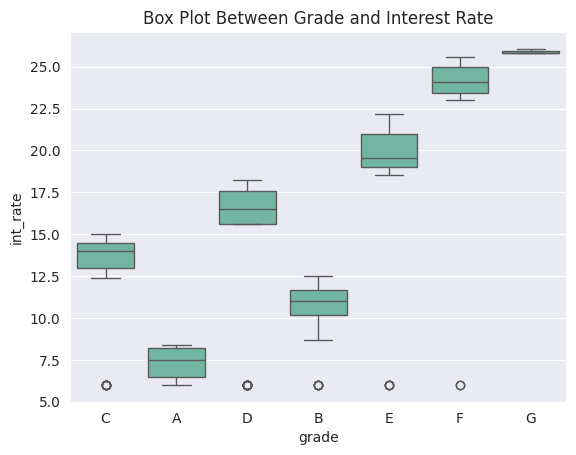

In [44]:
# Showing the relationship of int_rate with grade

sns.boxplot(x="grade", y="int_rate", data=Loan_Data_F)
plt.title("Box Plot Between Grade and Interest Rate")
plt.show()

### *Grade has influence on interest rate on each loan approval based on credit and must be kept for further analysis*

In [45]:
# Figuring columns for data impuatation (if less than 8 unique values)

imput_cols = [col for col in Loan_Data_F.columns if Loan_Data_F[col].nunique() <8]

# Print the columns

print("Imputed columns:", imput_cols)

Imputed columns: ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'inq_last_6mths', 'initial_list_status', 'application_type', 'debt_settlement_flag']


In [46]:
# Get unique features

for col in imput_cols:
    unique_features = Loan_Data_F[col].unique()
    print(f"Unique features for column {col}: {unique_features}")

Unique features for column term: [' 60 months' ' 36 months']
Unique features for column grade: ['C' 'A' 'D' 'B' 'E' 'F' 'G']
Unique features for column home_ownership: ['RENT' 'MORTGAGE' 'OWN']
Unique features for column verification_status: ['Source Verified' 'Not Verified' 'Verified']
Unique features for column loan_status: ['Fully Paid' 'Charged Off' 'Current']
Unique features for column inq_last_6mths: [0 2 1 3 4 5 6]
Unique features for column initial_list_status: ['w' 'f']
Unique features for column application_type: ['Individual']
Unique features for column debt_settlement_flag: ['N' 'Y']


In [47]:
# Drop application_type

Loan_Data_F.drop('application_type', axis=1, inplace=True)
Loan_Data_F

loan_amnt        term  int_rate grade sub_grade  \
0          15000   60 months     12.39     C        C1   
1          10400   36 months      6.99     A        A3   
2          21425   60 months     15.59     D        D1   
3          12800   60 months     17.14     D        D4   
4           7650   36 months     13.66     C        C3   
...          ...         ...       ...   ...       ...   
99995       8400   36 months      9.17     B        B1   
99996      10000   36 months     12.99     C        C1   
99997      30000   60 months     20.99     E        E4   
99998       8475   36 months     24.99     F        F4   
99999      25000   36 months     10.15     B        B2   

                             emp_title emp_length home_ownership  annual_inc  \
0                           MANAGEMENT  10+ years           RENT     78000.0   
1       Truck Driver Delivery Personel    8 years       MORTGAGE     58000.0   
2      Programming Analysis Supervisor    6 years           RENT     63800.0   
3            Senior Sales Professional  10+ years       MORTGAGE    125000.0   
4                 Technical Specialist   < 1 year           RENT     50000.0   
...                                ...        ...            ...         ...   
99995                Software Engineer    2 years       MORTGAGE     91000.0   
99996   Assistant Professor of English    3 years           RENT     53133.0   
99997                Facilities Tech 3  10+ years           RENT     78000.0   
99998         Records Examiner Analyst  10+ years           RENT     52000.0   
99999    Occupational Theapy Assistant    3 years            OWN     60000.0   

      verification_status  ... num_op_rev_tl num_rev_accts num_tl_90g_dpd_24m  \
0         Source Verified  ...             5             9                  0   
1            Not Verified  ...            14            32                  0   
2         Source Verified  ...             5            18                  0   
3                Verified  ...             5             7                  0   
4         Source Verified  ...             4             8                  0   
...                   ...  ...           ...           ...                ...   
99995     Source Verified  ...             3             7                  0   
99996        Not Verified  ...             9            13                  0   
99997            Verified  ...            15            22                  0   
99998            Verified  ...             8            18                  1   
99999     Source Verified  ...            10            19                  0   

       num_tl_op_past_12m  pct_tl_nvr_dlq percent_bc_gt_75  total_bal_ex_mort  \
0                       4           100.0              0.0             149140   
1                       4            83.3             14.3              15030   
2                       2            91.4            100.0              42315   
3                       0            76.9            100.0              18007   
4                       2           100.0            100.0              64426   
...                   ...             ...              ...                ...   
99995                   2            93.7             50.0              20872   
99996                   1           100.0             11.1              46413   
99997                   4            93.3            100.0              45447   
99998                   6            86.4            100.0              31247   
99999                   3           100.0             40.0              71301   

       total_bc_limit  total_il_high_credit_limit  debt_settlement_flag  
0               10000                       12000                     N  
1               13000                       11325                     N  
2               15000                       35573                     N  
3                4400                       18000                     N  
4                4900            

In [48]:
# Figuring columns for data impuatation (if less than 8 unique values)

imput_cols = [col for col in Loan_Data_F.columns if Loan_Data_F[col].nunique() <8]

# Print the columns

print("Imputed columns:", imput_cols)

Imputed columns: ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'inq_last_6mths', 'initial_list_status', 'debt_settlement_flag']


In [49]:
# Get unique features

for col in imput_cols:
    unique_features = Loan_Data_F[col].unique()
    print(f"Unique features for column {col}: {unique_features}")

Unique features for column term: [' 60 months' ' 36 months']
Unique features for column grade: ['C' 'A' 'D' 'B' 'E' 'F' 'G']
Unique features for column home_ownership: ['RENT' 'MORTGAGE' 'OWN']
Unique features for column verification_status: ['Source Verified' 'Not Verified' 'Verified']
Unique features for column loan_status: ['Fully Paid' 'Charged Off' 'Current']
Unique features for column inq_last_6mths: [0 2 1 3 4 5 6]
Unique features for column initial_list_status: ['w' 'f']
Unique features for column debt_settlement_flag: ['N' 'Y']


In [50]:
# Using label encoder to replace the columns

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

Loan_Data_F = Loan_Data_F.dropna(subset= imput_cols) # Drop NA's before imputation

for col in imput_cols:
    Loan_Data_F[col] = le.fit_transform(Loan_Data_F[col])
    print(col)
    print(Loan_Data_F[col].unique())
    print()

Loan_Data_F

term
[1 0]

grade
[2 0 3 1 4 5 6]

home_ownership
[2 0 1]

verification_status
[1 0 2]

loan_status
[2 0 1]

inq_last_6mths
[0 2 1 3 4 5 6]

initial_list_status
[1 0]

debt_settlement_flag
[0 1]



loan_amnt  term  int_rate  grade sub_grade  \
0          15000     1     12.39      2        C1   
1          10400     0      6.99      0        A3   
2          21425     1     15.59      3        D1   
3          12800     1     17.14      3        D4   
4           7650     0     13.66      2        C3   
...          ...   ...       ...    ...       ...   
99995       8400     0      9.17      1        B1   
99996      10000     0     12.99      2        C1   
99997      30000     1     20.99      4        E4   
99998       8475     0     24.99      5        F4   
99999      25000     0     10.15      1        B2   

                             emp_title emp_length  home_ownership  annual_inc  \
0                           MANAGEMENT  10+ years               2     78000.0   
1       Truck Driver Delivery Personel    8 years               0     58000.0   
2      Programming Analysis Supervisor    6 years               2     63800.0   
3            Senior Sales Professional  10+ years               0    125000.0   
4                 Technical Specialist   < 1 year               2     50000.0   
...                                ...        ...             ...         ...   
99995                Software Engineer    2 years               0     91000.0   
99996   Assistant Professor of English    3 years               2     53133.0   
99997                Facilities Tech 3  10+ years               2     78000.0   
99998         Records Examiner Analyst  10+ years               2     52000.0   
99999    Occupational Theapy Assistant    3 years               1     60000.0   

       verification_status  ...  num_op_rev_tl num_rev_accts  \
0                        1  ...              5             9   
1                        0  ...             14            32   
2                        1  ...              5            18   
3                        2  ...              5             7   
4                        1  ...              4             8   
...                    ...  ...            ...           ...   
99995                    1  ...              3             7   
99996                    0  ...              9            13   
99997                    2  ...             15            22   
99998                    2  ...              8            18   
99999                    1  ...             10            19   

      num_tl_90g_dpd_24m  num_tl_op_past_12m  pct_tl_nvr_dlq percent_bc_gt_75  \
0                      0                   4           100.0              0.0   
1                      0                   4            83.3             14.3   
2                      0                   2            91.4            100.0   
3                      0                   0            76.9            100.0   
4                      0                   2           100.0            100.0   
...                  ...                 ...             ...              ...   
99995                  0                   2            93.7             50.0   
99996                  0                   1           100.0             11.1   
99997                  0                   4            93.3            100.0   
99998                  1                   6            86.4            100.0   
99999                  0                   3           100.0             40.0   

       total_bal_ex_mort  total_bc_limit  total_il_high_credit_limit  \
0                 149140           10000                       12000   
1                  15030           13000                       11325   
2                  42315           15000                       35573   
3                  18007            4400                       18000   
4                  64426            4900                       64031   
...                  ...             ...                         ...   
99995              20872           11000                       15473   
99996              46413           24300                       39849   
99997  

Unique features for column term: [' 60 months' ' 36 months']

Unique features for column grade: ['C' 'A' 'D' 'B' 'E' 'F' 'G']

Unique features for column home_ownership: ['RENT' 'MORTGAGE' 'OWN']

Unique features for column verification_status: ['Source Verified' 'Not Verified' 'Verified']

Unique features for column loan_status: ['Fully Paid' 'Charged Off' 'Current']

Unique features for column inq_last_6mths: [0 2 1 3 4 5 6]

Unique features for column initial_list_status: ['w' 'f']

Unique features for column debt_settlement_flag: ['N' 'Y']


term
[1 0]

grade
[2 0 3 1 4 5 6]

home_ownership
[2 0 1]

verification_status
[1 0 2]

loan_status
[2 0 1]

inq_last_6mths
[0 2 1 3 4 5 6]

initial_list_status
[1 0]

debt_settlement_flag
[0 1]

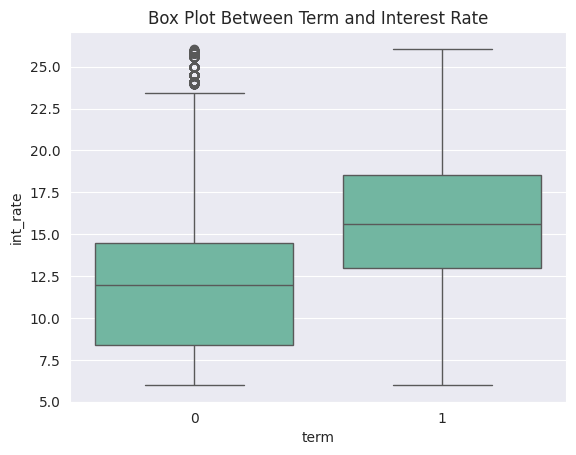

In [51]:
# showing a chart to display the relationship between term and int_rate

sns.boxplot(x="term", y="int_rate", data=Loan_Data_F)
plt.title("Box Plot Between Term and Interest Rate")
plt.show()

In [52]:
Loan_Data_F['int_rate'] = Loan_Data_F['int_rate'].astype('str')

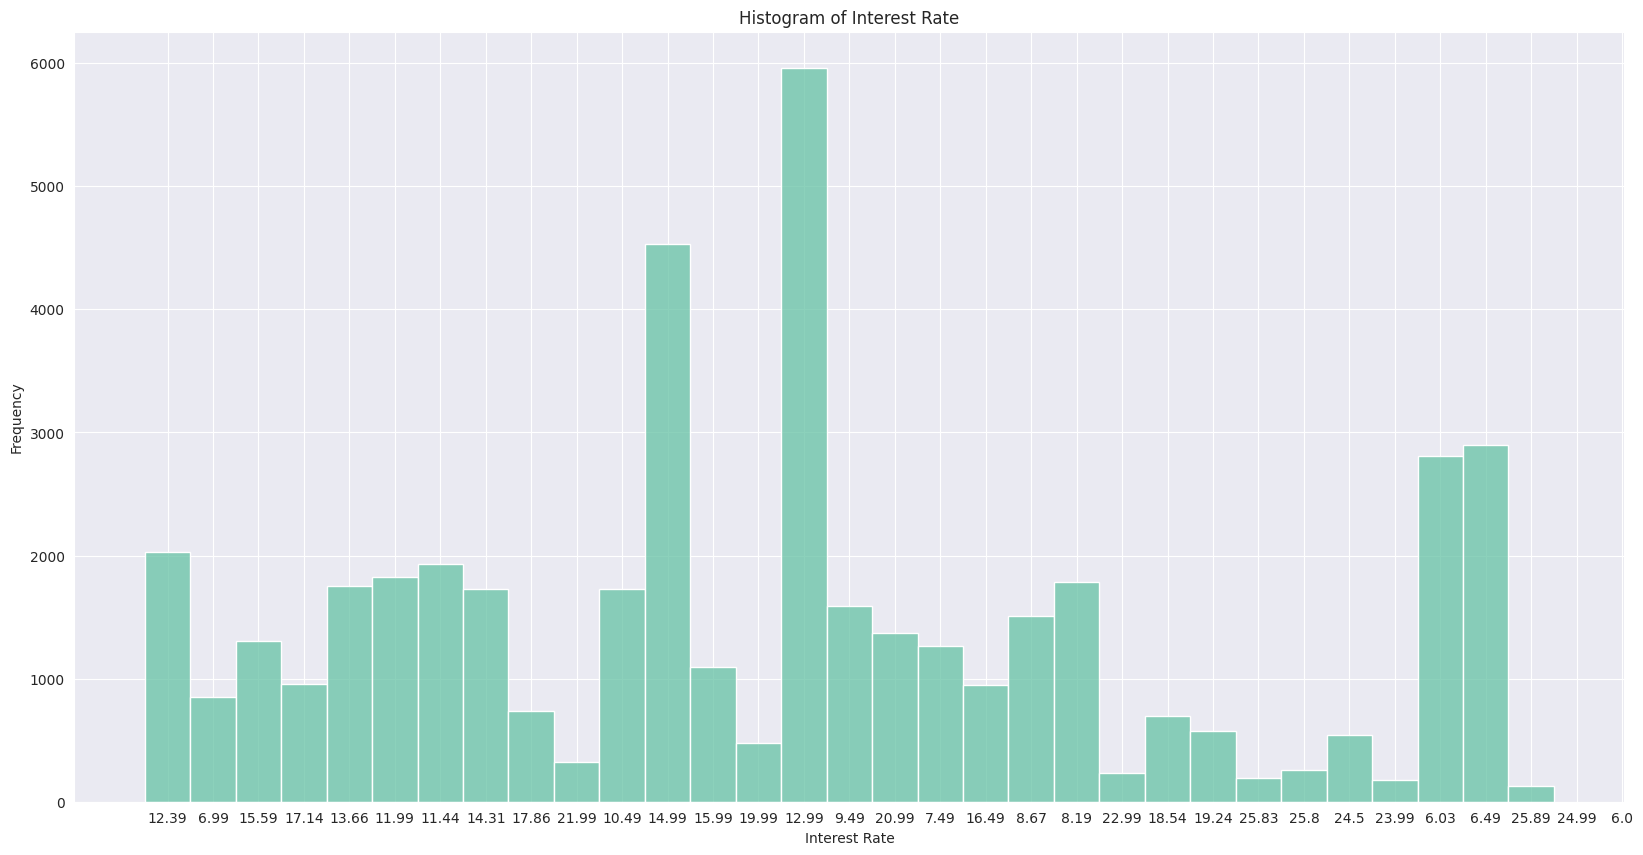

In [53]:
# Range for the interest rate

int_rate_min = 0
int_rate_max = 30
bin_width = 1

# The number of bins based on the range and bin width

num_bins = int((int_rate_max - int_rate_min) / bin_width)

# Figure and axes with the desired figsize

fig, ax = plt.subplots(figsize=(20, 10))

# Histogram plot with specified range

sns.histplot(Loan_Data_F['int_rate'], bins=num_bins, binrange=(int_rate_min, int_rate_max), ax=ax)

plt.title("Histogram of Interest Rate")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.show()

## **Erroneous Values**

### *Detecting special characters in the Data*

In [54]:
import re # Regular expression model (regex)

def detect_special_characters(data):

  special_characters = {}
  for column in data.columns:
    special_characters[column] = []
    for value in data[column]:
      if isinstance(value, str):
        for char in value:
          if not char.isalnum() and not char.isspace():
            special_characters[column].append(char)
  return special_characters

# Detect special characters in the New_Loan_Data DataFrame

special_characters = detect_special_characters(Loan_Data_F)

# Print the results
for column, characters in special_characters.items():
  if characters:
    print(f"Special characters found in column '{column}': {characters}")
  else:
    print(f"No special characters found in column '{column}'")

No special characters found in column 'loan_amnt'
No special characters found in column 'term'
Special characters found in column 'int_rate': ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.

In [55]:
# Changing special characters (# Columns with special Characters int_rate, emp_title, emp_length, purpose, earliest_cr_line, last_pymnt_d, last_credit_pull_d)

Loan_Data_F['title'] = Loan_Data_F['title'].str.replace(r"[_/&\(\)\-,\.:;?]", " ", regex=True)
Loan_Data_F['purpose'] = Loan_Data_F['purpose'].str.replace(r"[_/&\(\)\-,\.:;?]", " ", regex=True)
Loan_Data_F['earliest_cr_line'] = Loan_Data_F['earliest_cr_line'].str.replace(r"[_/&\(\)\-,\.:;?]", " ", regex=True)
Loan_Data_F['last_pymnt_d'] = Loan_Data_F['last_pymnt_d'].str.replace(r"[_/&\(\)\-,\.:;?]", " ", regex=True)
Loan_Data_F['last_credit_pull_d'] = Loan_Data_F['last_credit_pull_d'].str.replace(r"[_/&\(\)\-,\.:;?]", " ", regex=True)

Loan_Data_F['emp_title'] = Loan_Data_F['emp_title'].str.replace(r"[_/&\(\)\-,\.:;?#'//\\~%±[`}|!]", " ", regex=True)

In [56]:
# Checking the Unique features for columns with special Characters int_rate, emp_title, emp_length, purpose, earliest_cr_line, last_pymnt_d, last_credit_pull_d

columns_with_special_characters = ['int_rate', 'emp_title', 'emp_length', 'purpose', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']

for col in columns_with_special_characters:
    unique_values = Loan_Data_F[col].unique()
    print(f"Unique values for {col}: {unique_values}")

Unique values for int_rate: ['12.39' '6.99' '15.59' '17.14' '13.66' '11.99' '11.44' '14.31' '17.86'
 '21.99' '10.49' '14.99' '15.99' '19.99' '12.99' '9.49' '20.99' '7.49'
 '16.49' '8.67' '8.19' '22.99' '18.54' '19.24' '25.83' '25.8' '24.5'
 '23.99' '6.03' '6.49' '25.89' '24.99' '6.0' '25.99' '25.57' '26.06'
 '17.57' '14.49' '13.98' '12.49' '16.29' '10.15' '8.39' '23.43' '15.61'
 '18.24' '9.17' '16.99' '7.69' '10.99' '20.2' '19.52' '13.35' '22.15'
 '11.67' '18.99' '7.12' '24.08']
Unique values for emp_title: ['MANAGEMENT' 'Truck Driver Delivery Personel'
 'Programming Analysis Supervisor' ... 'Facilities Tech 3'
 'Records Examiner Analyst' 'Occupational Theapy Assistant']
Unique values for emp_length: ['10+ years' '8 years' '6 years' '< 1 year' '2 years' '9 years' '7 years'
 '5 years' '3 years' '1 year' nan '4 years']
Unique values for purpose: ['debt consolidation' 'credit card' 'car' 'home improvement' 'house'
 'medical' 'other' 'moving' 'major purchase' 'vacation' 'small business'
 '

In [57]:
# Changing < 1 year to 0.5 and 10+ years to 10 and format the rest as numeric for emp_length

def transform_emp_length(value):
    if isinstance(value, float):
        return value

    if value == "< 1 year":
        return 0.5
    elif value == "10+ years":
        return 10
    else:
        try:
            return float(value.replace(" years", ""))
        except ValueError:
            return np.nan

Loan_Data_F["emp_length"] = Loan_Data_F["emp_length"].apply(transform_emp_length)

In [58]:
Loan_Data_F['emp_length'].unique()

array([10. ,  8. ,  6. ,  0.5,  2. ,  9. ,  7. ,  5. ,  3. ,  nan,  4. ])

In [59]:
# Checking further special characters in new_loan_data

def detect_special_characters(data):

  special_characters = {}
  for column in data.columns:
    special_characters[column] = []
    for value in data[column]:
      if isinstance(value, str):
        for char in value:
          if not char.isalnum() and not char.isspace():
            special_characters[column].append(char)
  return special_characters

# Detect special characters in the New_Loan_Data DataFrame

special_characters = detect_special_characters(Loan_Data_F)

# Print the results
for column, characters in special_characters.items():
  if characters:
    print(f"Special characters found in column '{column}': {characters}")
  else:
    print(f"No special characters found in column '{column}'")

No special characters found in column 'loan_amnt'
No special characters found in column 'term'
Special characters found in column 'int_rate': ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.

In [60]:
# Numeric & Non_numeric

numeric_cols = Loan_Data_F.select_dtypes(include=[np.number]).columns
non_numeric_cols = Loan_Data_F.select_dtypes(exclude=[np.number]).columns

print("Numeric Columns: ", numeric_cols)

print("\nNon-Numeric Columns: ", non_numeric_cols)

Numeric Columns:  Index(['loan_amnt', 'term', 'grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'dti',
       'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'last_fico_range_high', 'last_fico_range_low', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_tl_90g_dpd_24m',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'per

In [61]:
# Change int_rate dtype to float

Loan_Data_F['int_rate'] = Loan_Data_F['int_rate'].astype(float)

In [62]:
non_numeric_cols = Loan_Data_F.select_dtypes(exclude=[np.number]).columns
non_numeric_cols

Index(['sub_grade', 'emp_title', 'purpose', 'title', 'earliest_cr_line',
       'last_pymnt_d', 'last_credit_pull_d'],
      dtype='object')

In [63]:
Loan_Data_F.shape

(98863, 64)

In [64]:
# Drop non_numeric_cols

Loan_Data_F.drop(non_numeric_cols, axis=1, inplace=True)
Loan_Data_F

loan_amnt  term  int_rate  grade  emp_length  home_ownership  \
0          15000     1     12.39      2        10.0               2   
1          10400     0      6.99      0         8.0               0   
2          21425     1     15.59      3         6.0               2   
3          12800     1     17.14      3        10.0               0   
4           7650     0     13.66      2         0.5               2   
...          ...   ...       ...    ...         ...             ...   
99995       8400     0      9.17      1         2.0               0   
99996      10000     0     12.99      2         3.0               2   
99997      30000     1     20.99      4        10.0               2   
99998       8475     0     24.99      5        10.0               2   
99999      25000     0     10.15      1         3.0               1   

       annual_inc  verification_status  loan_status    dti  ...  \
0         78000.0                    1            2  12.03  ...   
1         58000.0                    0            0  14.92  ...   
2         63800.0                    1            2  18.49  ...   
3        125000.0                    2            1   8.31  ...   
4         50000.0                    1            0  34.81  ...   
...           ...                  ...          ...    ...  ...   
99995     91000.0                    1            2   7.78  ...   
99996     53133.0                    0            2  15.25  ...   
99997     78000.0                    2            1  23.75  ...   
99998     52000.0                    2            0  17.61  ...   
99999     60000.0                    1            2  27.82  ...   

       num_op_rev_tl  num_rev_accts  num_tl_90g_dpd_24m  num_tl_op_past_12m  \
0                  5              9                   0                   4   
1                 14             32                   0                   4   
2                  5             18                   0                   2   
3                  5              7                   0                   0   
4                  4              8                   0                   2   
...              ...            ...                 ...                 ...   
99995              3              7                   0                   2   
99996              9             13                   0                   1   
99997             15             22                   0                   4   
99998              8             18                   1                   6   
99999             10             19                   0                   3   

       pct_tl_nvr_dlq  percent_bc_gt_75  total_bal_ex_mort  total_bc_limit  \
0               100.0               0.0             149140           10000   
1                83.3              14.3              15030           13000   
2                91.4             100.0              42315           15000   
3                76.9             100.0              18007            4400   
4               100.0             100.0              64426            4900   
...               ...               ...                ...             ...   
99995            93.7              50.0              20872           11000   
99996           100.0              11.1              46413           24300   
99997            93.3             100.0              45447           22300   
99998            86.4             100.0              31247            2700   
99999           100.0              40.0              71301           40300   

       total_il_high_credit_limit  debt_settlement_flag  
0                           12000                     0  
1                           11325                     0  
2                           35573                     0  
3                           18000                     0  
4                           64031                     0  
...                           ...                   ...  
99995                       15473                     0  

In [65]:
Loan_Data_F.shape

(98863, 57)

In [66]:
# Checking for further NAs

for col in Loan_Data_F.columns:
    percentage_of_missing = np.mean(Loan_Data_F[col].isnull())
    print('{} - {}%'.format(col, round(percentage_of_missing*100)))

loan_amnt - 0%
term - 0%
int_rate - 0%
grade - 0%
emp_length - 12%
home_ownership - 0%
annual_inc - 0%
verification_status - 0%
loan_status - 0%
dti - 0%
delinq_2yrs - 0%
fico_range_low - 0%
inq_last_6mths - 0%
open_acc - 0%
pub_rec - 0%
revol_bal - 0%
revol_util - 0%
total_acc - 0%
initial_list_status - 0%
out_prncp - 0%
total_rec_int - 0%
total_rec_late_fee - 0%
recoveries - 0%
last_pymnt_amnt - 0%
last_fico_range_high - 0%
last_fico_range_low - 0%
tot_coll_amt - 0%
tot_cur_bal - 0%
total_rev_hi_lim - 0%
acc_open_past_24mths - 0%
avg_cur_bal - 0%
bc_open_to_buy - 1%
bc_util - 1%
delinq_amnt - 0%
mo_sin_old_il_acct - 3%
mo_sin_old_rev_tl_op - 0%
mo_sin_rcnt_rev_tl_op - 0%
mo_sin_rcnt_tl - 0%
mort_acc - 0%
mths_since_recent_bc - 1%
mths_since_recent_inq - 10%
num_accts_ever_120_pd - 0%
num_actv_bc_tl - 0%
num_actv_rev_tl - 0%
num_bc_sats - 0%
num_bc_tl - 0%
num_il_tl - 0%
num_op_rev_tl - 0%
num_rev_accts - 0%
num_tl_90g_dpd_24m - 0%
num_tl_op_past_12m - 0%
pct_tl_nvr_dlq - 0%
percent_b

In [67]:
# KNN Imputation

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
Loan_Data_F = pd.DataFrame(imputer.fit_transform(Loan_Data_F), columns=Loan_Data_F.columns)
Loan_Data_F

loan_amnt  term  int_rate  grade  emp_length  home_ownership  \
0        15000.0   1.0     12.39    2.0        10.0             2.0   
1        10400.0   0.0      6.99    0.0         8.0             0.0   
2        21425.0   1.0     15.59    3.0         6.0             2.0   
3        12800.0   1.0     17.14    3.0        10.0             0.0   
4         7650.0   0.0     13.66    2.0         0.5             2.0   
...          ...   ...       ...    ...         ...             ...   
98858     8400.0   0.0      9.17    1.0         2.0             0.0   
98859    10000.0   0.0     12.99    2.0         3.0             2.0   
98860    30000.0   1.0     20.99    4.0        10.0             2.0   
98861     8475.0   0.0     24.99    5.0        10.0             2.0   
98862    25000.0   0.0     10.15    1.0         3.0             1.0   

       annual_inc  verification_status  loan_status    dti  ...  \
0         78000.0                  1.0          2.0  12.03  ...   
1         58000.0                  0.0          0.0  14.92  ...   
2         63800.0                  1.0          2.0  18.49  ...   
3        125000.0                  2.0          1.0   8.31  ...   
4         50000.0                  1.0          0.0  34.81  ...   
...           ...                  ...          ...    ...  ...   
98858     91000.0                  1.0          2.0   7.78  ...   
98859     53133.0                  0.0          2.0  15.25  ...   
98860     78000.0                  2.0          1.0  23.75  ...   
98861     52000.0                  2.0          0.0  17.61  ...   
98862     60000.0                  1.0          2.0  27.82  ...   

       num_op_rev_tl  num_rev_accts  num_tl_90g_dpd_24m  num_tl_op_past_12m  \
0                5.0            9.0                 0.0                 4.0   
1               14.0           32.0                 0.0                 4.0   
2                5.0           18.0                 0.0                 2.0   
3                5.0            7.0                 0.0                 0.0   
4                4.0            8.0                 0.0                 2.0   
...              ...            ...                 ...                 ...   
98858            3.0            7.0                 0.0                 2.0   
98859            9.0           13.0                 0.0                 1.0   
98860           15.0           22.0                 0.0                 4.0   
98861            8.0           18.0                 1.0                 6.0   
98862           10.0           19.0                 0.0                 3.0   

       pct_tl_nvr_dlq  percent_bc_gt_75  total_bal_ex_mort  total_bc_limit  \
0               100.0               0.0           149140.0         10000.0   
1                83.3              14.3            15030.0         13000.0   
2                91.4             100.0            42315.0         15000.0   
3                76.9             100.0            18007.0          4400.0   
4               100.0             100.0            64426.0          4900.0   
...               ...               ...                ...             ...   
98858            93.7              50.0            20872.0         11000.0   
98859           100.0              11.1            46413.0         24300.0   
98860            93.3             100.0            45447.0         22300.0   
98861            86.4             100.0            31247.0          2700.0   
98862           100.0              40.0            71301.0         40300.0   

       total_il_high_credit_limit  debt_settlement_flag  
0                         12000.0                   0.0  
1                         11325.0                   0.0  
2                         35573.0                   0.0  
3                         18000.0                   0.0  
4                         64031.0                   0.0  
...                           ...                   ...  
98858                     15473.0                   0.0  

In [68]:
# Check further NAs for Numeric_col

for col in numeric_cols:
    null_count = Loan_Data_F[col].isnull().sum()
    print(f"Column: {col}, Null values: {null_count}")

Column: loan_amnt, Null values: 0
Column: term, Null values: 0
Column: grade, Null values: 0
Column: emp_length, Null values: 0
Column: home_ownership, Null values: 0
Column: annual_inc, Null values: 0
Column: verification_status, Null values: 0
Column: loan_status, Null values: 0
Column: dti, Null values: 0
Column: delinq_2yrs, Null values: 0
Column: fico_range_low, Null values: 0
Column: inq_last_6mths, Null values: 0
Column: open_acc, Null values: 0
Column: pub_rec, Null values: 0
Column: revol_bal, Null values: 0
Column: revol_util, Null values: 0
Column: total_acc, Null values: 0
Column: initial_list_status, Null values: 0
Column: out_prncp, Null values: 0
Column: total_rec_int, Null values: 0
Column: total_rec_late_fee, Null values: 0
Column: recoveries, Null values: 0
Column: last_pymnt_amnt, Null values: 0
Column: last_fico_range_high, Null values: 0
Column: last_fico_range_low, Null values: 0
Column: tot_coll_amt, Null values: 0
Column: tot_cur_bal, Null values: 0
Column: tota

In [69]:
Loan_Data_F.shape

(98863, 57)

In [70]:
Loan_Data_F["loan_status"].value_counts()

loan_status
2.0    69981
0.0    16156
1.0    12726
Name: count, dtype: int64

***Loan_Status Variables***
0. Charged Off
1. Current
2. Fully Paid

In [71]:
# Checking the Unique features

for col in Loan_Data_F.columns:
    unique_values = Loan_Data_F[col].unique()
    print(f"Unique values for {col}: {unique_values}")

Unique values for loan_amnt: [15000. 10400. 21425. ... 30975. 29875. 30475.]
Unique values for term: [1. 0.]
Unique values for int_rate: [12.39  6.99 15.59 17.14 13.66 11.99 11.44 14.31 17.86 21.99 10.49 14.99
 15.99 19.99 12.99  9.49 20.99  7.49 16.49  8.67  8.19 22.99 18.54 19.24
 25.83 25.8  24.5  23.99  6.03  6.49 25.89 24.99  6.   25.99 25.57 26.06
 17.57 14.49 13.98 12.49 16.29 10.15  8.39 23.43 15.61 18.24  9.17 16.99
  7.69 10.99 20.2  19.52 13.35 22.15 11.67 18.99  7.12 24.08]
Unique values for grade: [2. 0. 3. 1. 4. 5. 6.]
Unique values for emp_length: [10.   8.   6.   0.5  2.   9.   7.   5.   3.   4.8  4.7  4.   2.7  3.2
  3.6  3.5  5.7  2.6  6.6  6.3  5.8  5.5  5.2  9.4  7.1  8.2  3.7  6.8
  5.4  6.4  4.1  2.4  1.7  6.2  7.4  7.2  8.1  3.9  4.4  7.8  8.8  8.6
  5.9  7.7  4.3  7.5  8.4  7.6  4.6  3.3  4.9  4.2  2.2  5.6  3.8  6.9
  6.5  3.4  4.5  5.3  6.1  1.8  2.9  9.2  9.8  2.5  0.8  3.1  1.4  6.7
  9.6  1.5  1.6  5.1  2.8  2.1  7.3  1.9  2.3  7.9  1.1  1.2  1.3  1. ]
Uniq

In [72]:
Loan_Data_F["home_ownership"].value_counts()

home_ownership
0.0    49146
2.0    39531
1.0    10186
Name: count, dtype: int64

*0 - Mortgage*
*1 - Own*
*2 - Rent*

In [73]:
# Correlation analysis

Loan_Data_F.corr().round(2)

loan_amnt  term  int_rate  grade  emp_length  \
loan_amnt                        1.00  0.41      0.11   0.11        0.10   
term                             0.41  1.00      0.40   0.40        0.07   
int_rate                         0.11  0.40      1.00   0.97       -0.00   
grade                            0.11  0.40      0.97   1.00       -0.00   
emp_length                       0.10  0.07     -0.00  -0.00        1.00   
home_ownership                  -0.21 -0.12      0.07   0.06       -0.20   
annual_inc                       0.38  0.06     -0.11  -0.11        0.07   
verification_status              0.37  0.20      0.26   0.25        0.05   
loan_status                     -0.12 -0.33     -0.30  -0.29       -0.01   
dti                              0.02  0.09      0.21   0.20        0.03   
delinq_2yrs                     -0.01 -0.01      0.05   0.04        0.02   
fico_range_low                   0.15  0.01     -0.38  -0.36        0.03   
inq_last_6mths                  -0.04 -0.02      0.22   0.22       -0.01   
open_acc                         0.19  0.08     -0.01  -0.01        0.03   
pub_rec                         -0.10 -0.04      0.06   0.05        0.02   
revol_bal                        0.34  0.10     -0.05  -0.05        0.09   
revol_util                       0.13  0.10      0.22   0.21        0.03   
total_acc                        0.21  0.10     -0.05  -0.05        0.09   
initial_list_status              0.14  0.34      0.04   0.04        0.03   
out_prncp                        0.33  0.52      0.15   0.15        0.06   
total_rec_int                    0.70  0.59      0.43   0.43        0.09   
total_rec_late_fee               0.06  0.01      0.07   0.07       -0.00   
recoveries                       0.15  0.12      0.18   0.17        0.01   
last_pymnt_amnt                  0.38  0.17      0.06   0.06        0.04   
last_fico_range_high             0.10 -0.04     -0.35  -0.34        0.02   
last_fico_range_low              0.08 -0.03     -0.28  -0.27        0.02   
tot_coll_amt                    -0.02 -0.01      0.01   0.00        0.00   
tot_cur_bal                      0.34  0.11     -0.09  -0.09        0.11   
total_rev_hi_lim                 0.27  0.06     -0.13  -0.13        0.07   
acc_open_past_24mths            -0.02  0.02      0.21   0.20        0.02   
avg_cur_bal                      0.25  0.08     -0.09  -0.09        0.10   
bc_open_to_buy                   0.22  0.01     -0.29  -0.28        0.03   
bc_util                          0.05  0.07      0.25   0.24        0.02   
delinq_amnt                      0.00 -0.00      0.01   0.01        0.00   
mo_sin_old_il_acct               0.15  0.08     -0.09  -0.08        0.12   
mo_sin_old_rev_tl_op             0.19  0.06     -0.14  -0.14        0.20   
mo_sin_rcnt_rev_tl_op            0.07  0.02     -0.11  -0.11        0.01   
mo_sin_rcnt_tl                   0.05  0.00     -0.14  -0.14       -0.01   
mort_acc                         0.24  0.10     -0.07  -0.07        0.19   
mths_since_recent_bc             0.05  0.02     -0.08  -0.08        0.03   
mths_since_recent_inq            0.02 -0.00     -0.16  -0.16        0.00   
num_accts_ever_120_pd           -0.06 -0.03      0.04   0.04        0.02   
num_actv_bc_tl                   0.21  0.07     -0.01  -0.01        0.07   
num_actv_rev_tl                  0.16  0.07      0.08   0.08        0.12   
num_bc_sats                      0.23  0.06     -0.08  -0.08        0.06   
num_bc_tl                        0.20  0.05     -0.11  -0.11        0.11   
num_il_tl                        0.07  0.07      0.01   0.01       -0.06   
num_op_rev_tl                    0.18  0.06     -0.00  -0.00        0.11   
num_rev_accts                    0.17  0.05     -0.06  -0.06        0.14   
num_tl_90g_dpd_24m              -0.03 -0.01      0.03   0.02       -0.00   
num_tl_op_past_12m              -0.05 -0.01      0.23   0.23        0.02   
pct_tl_nvr_dlq                   0.11  0.05     -0.06  -0.06       -0.03   


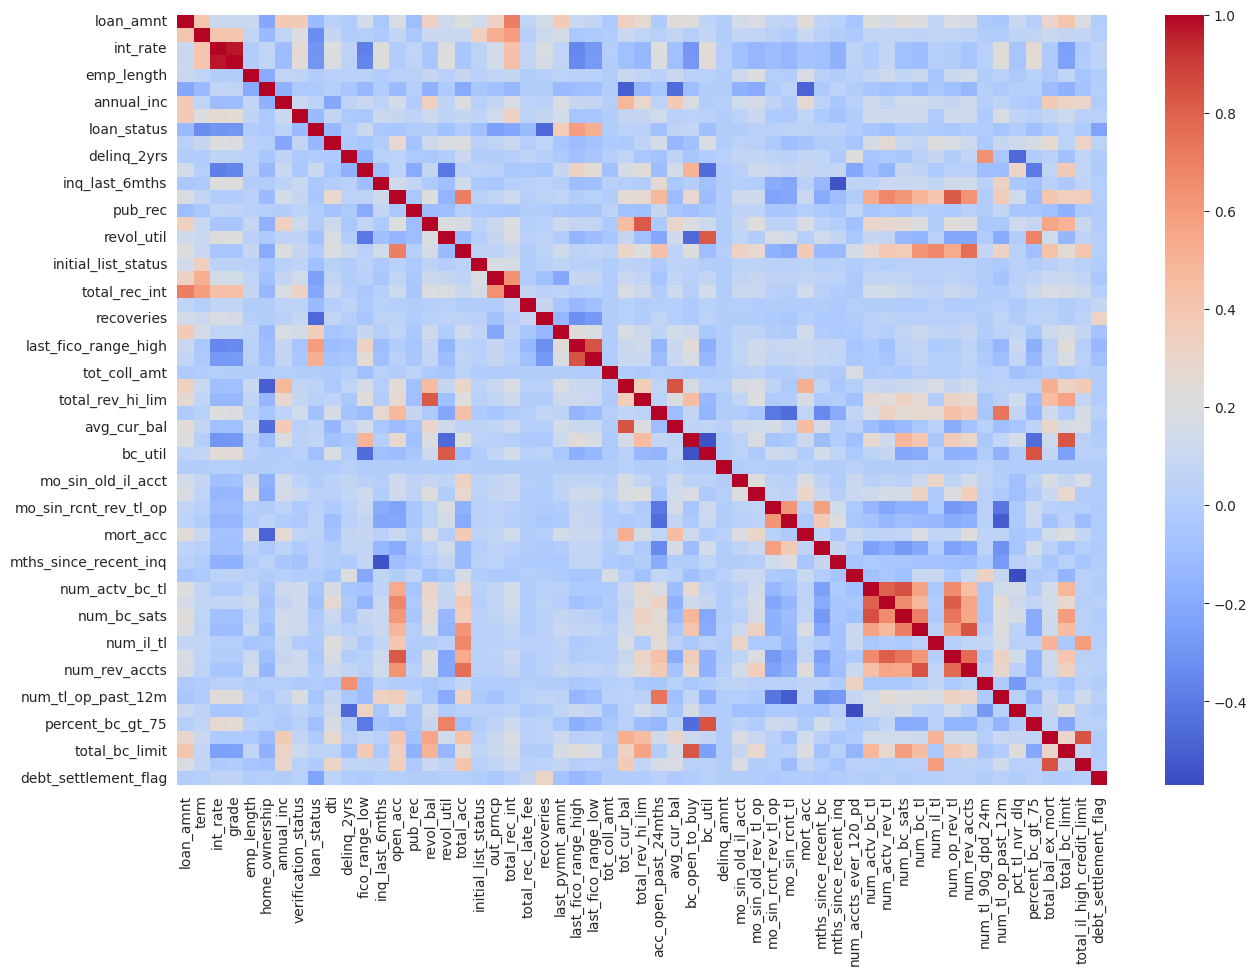

In [74]:
# Heatmap

plt.figure(figsize=(15, 10))
sns.heatmap(Loan_Data_F.corr().round(2), cmap='coolwarm')
plt.show()

## Distribution

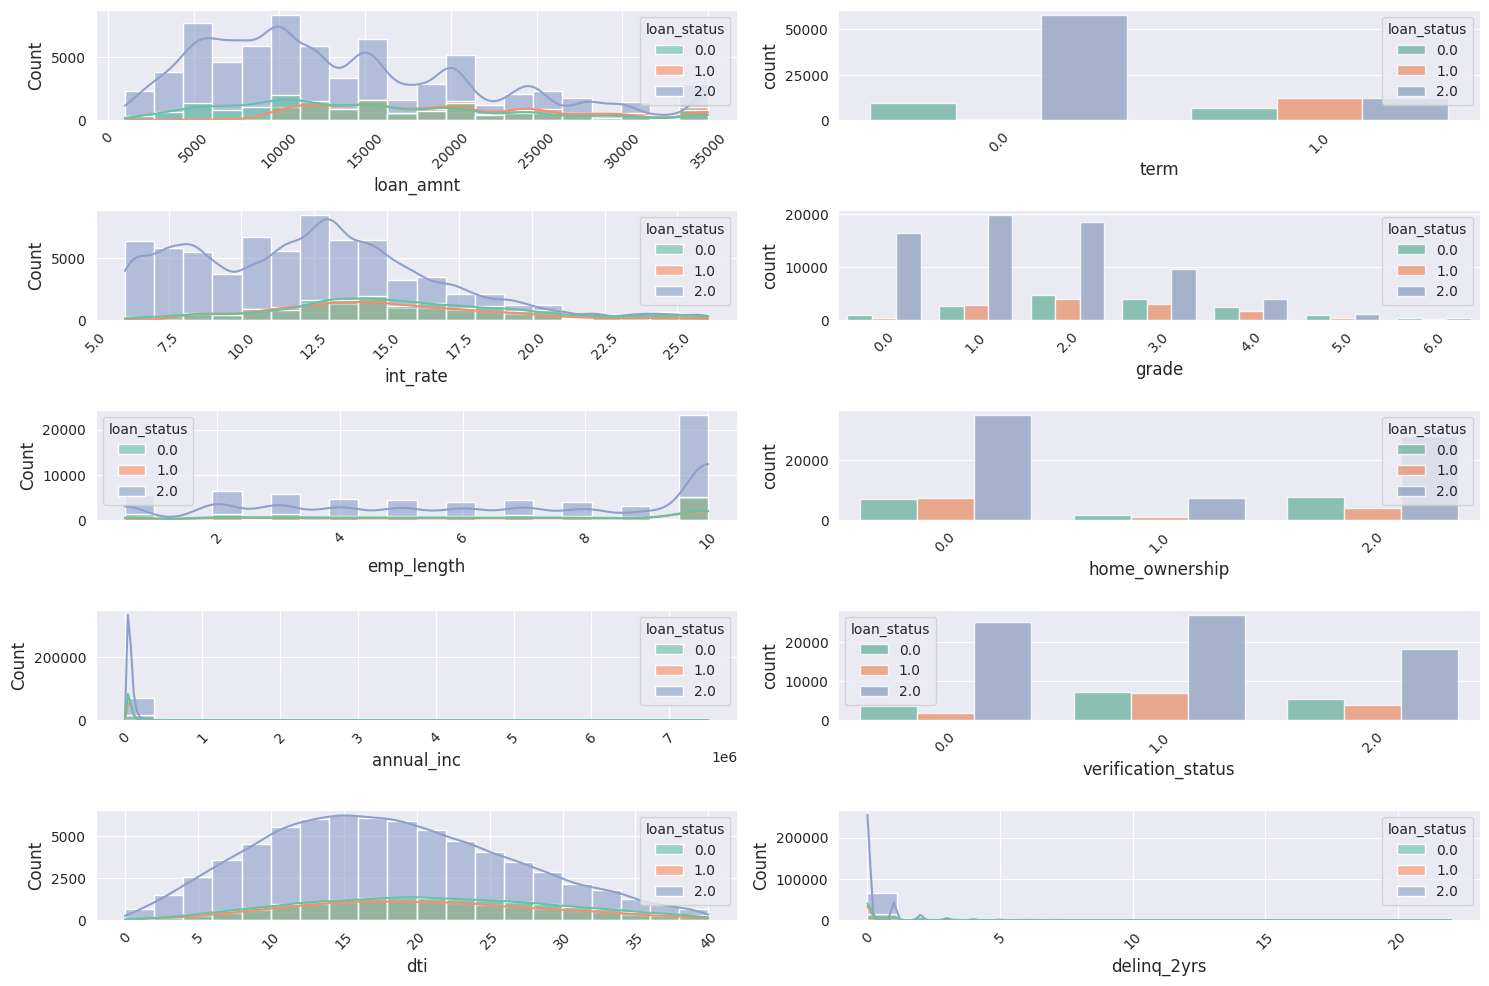

<Figure size 1500x800 with 0 Axes>

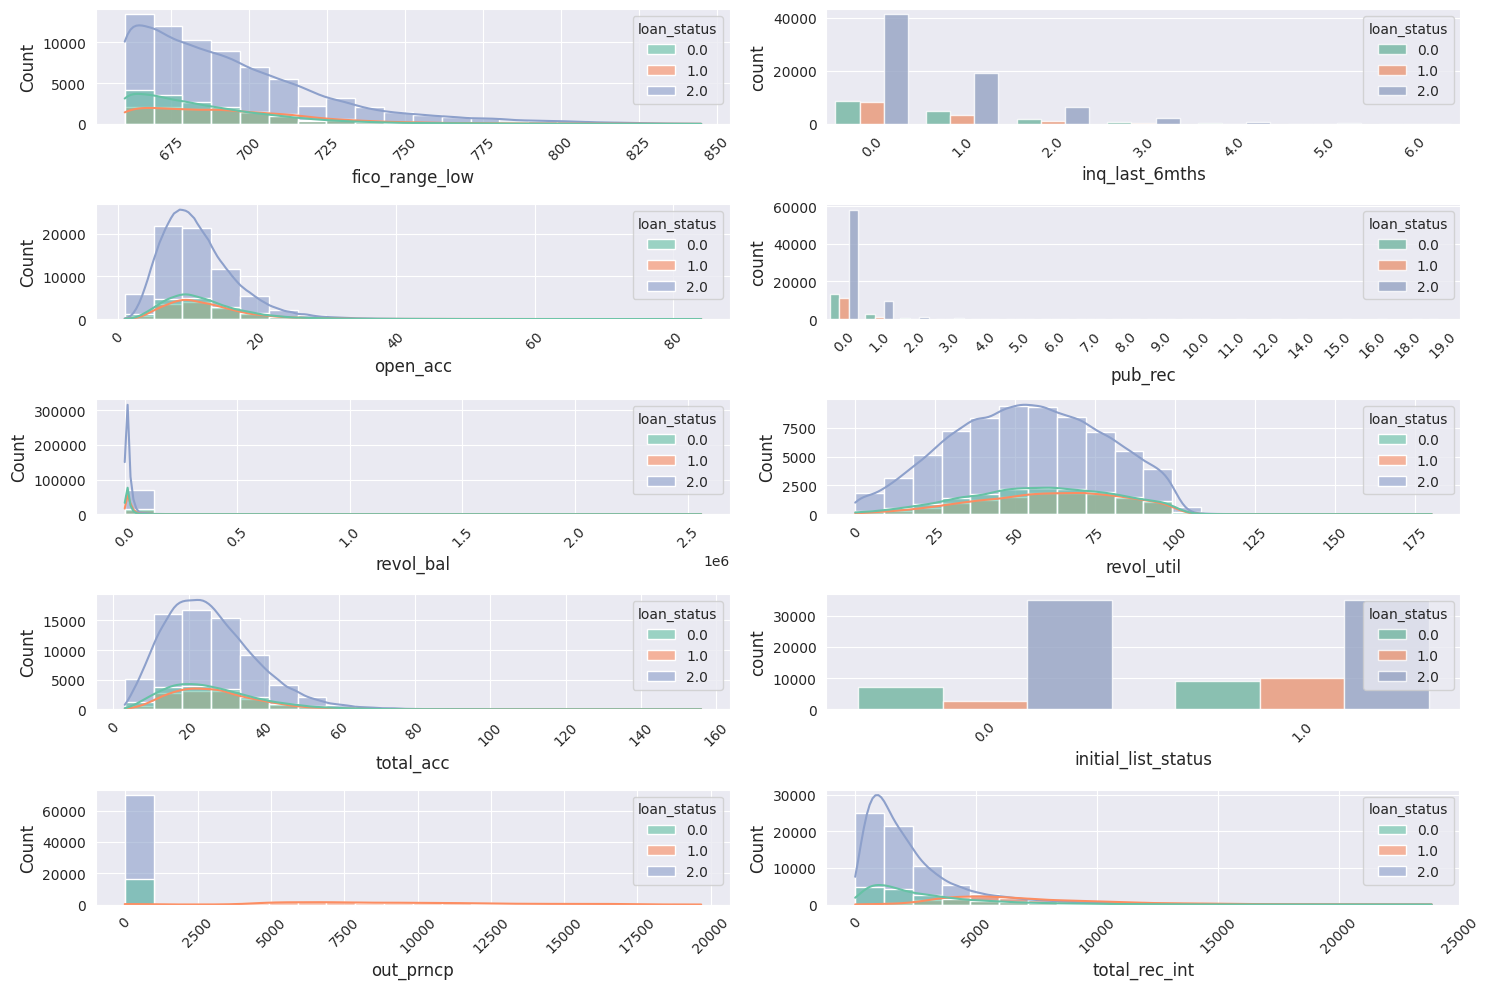

<Figure size 1500x800 with 0 Axes>

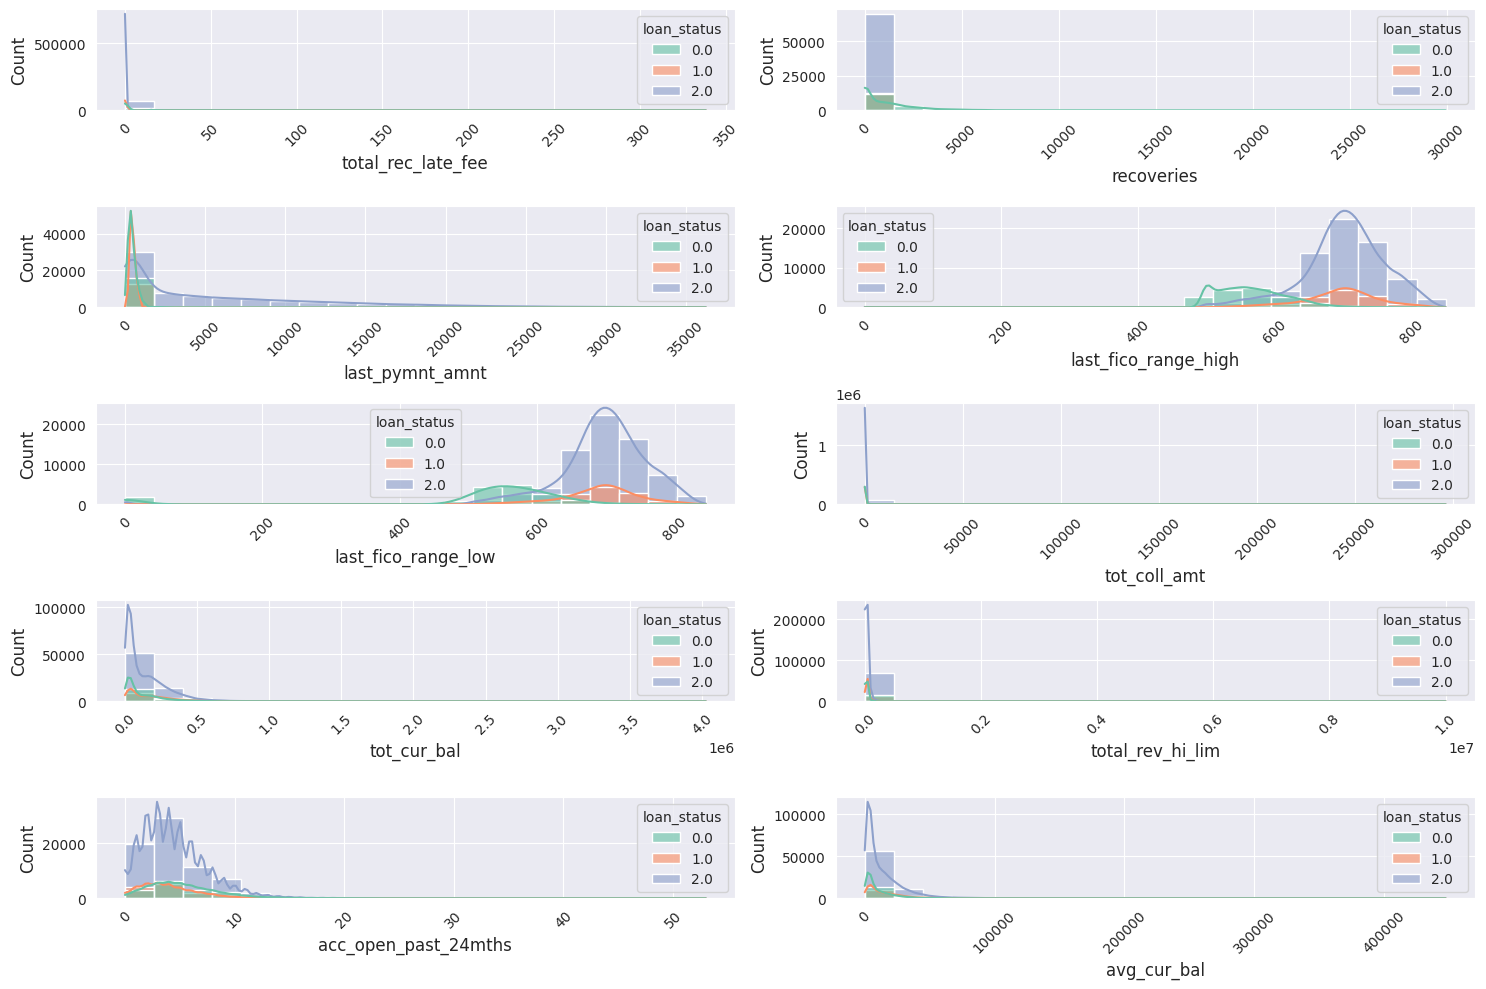

<Figure size 1500x800 with 0 Axes>

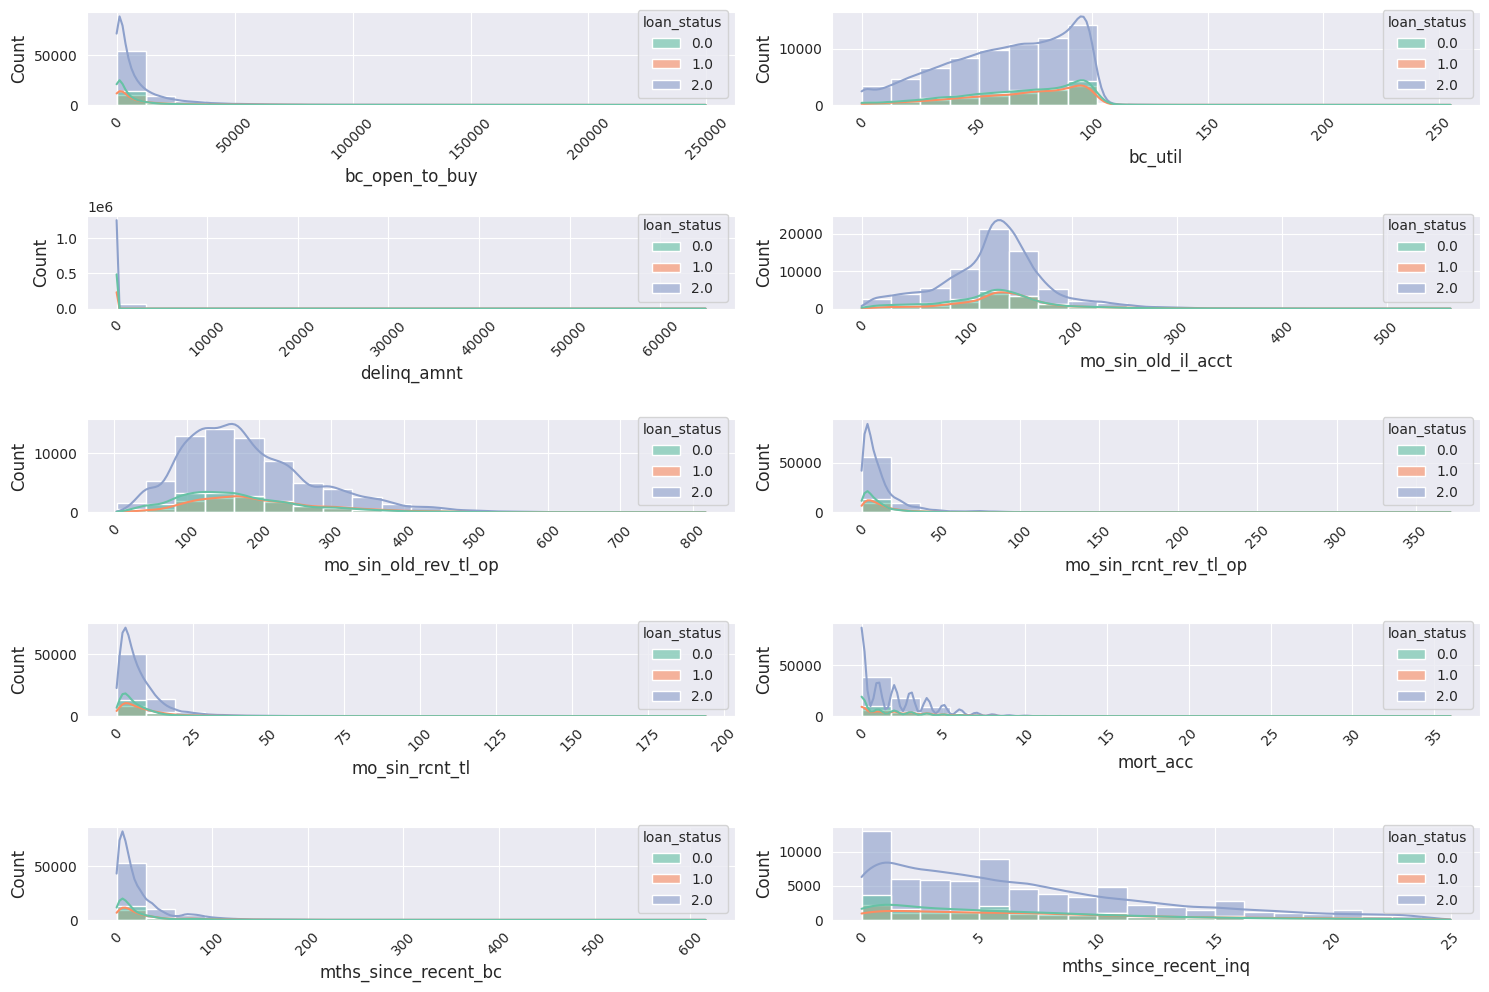

<Figure size 1500x800 with 0 Axes>

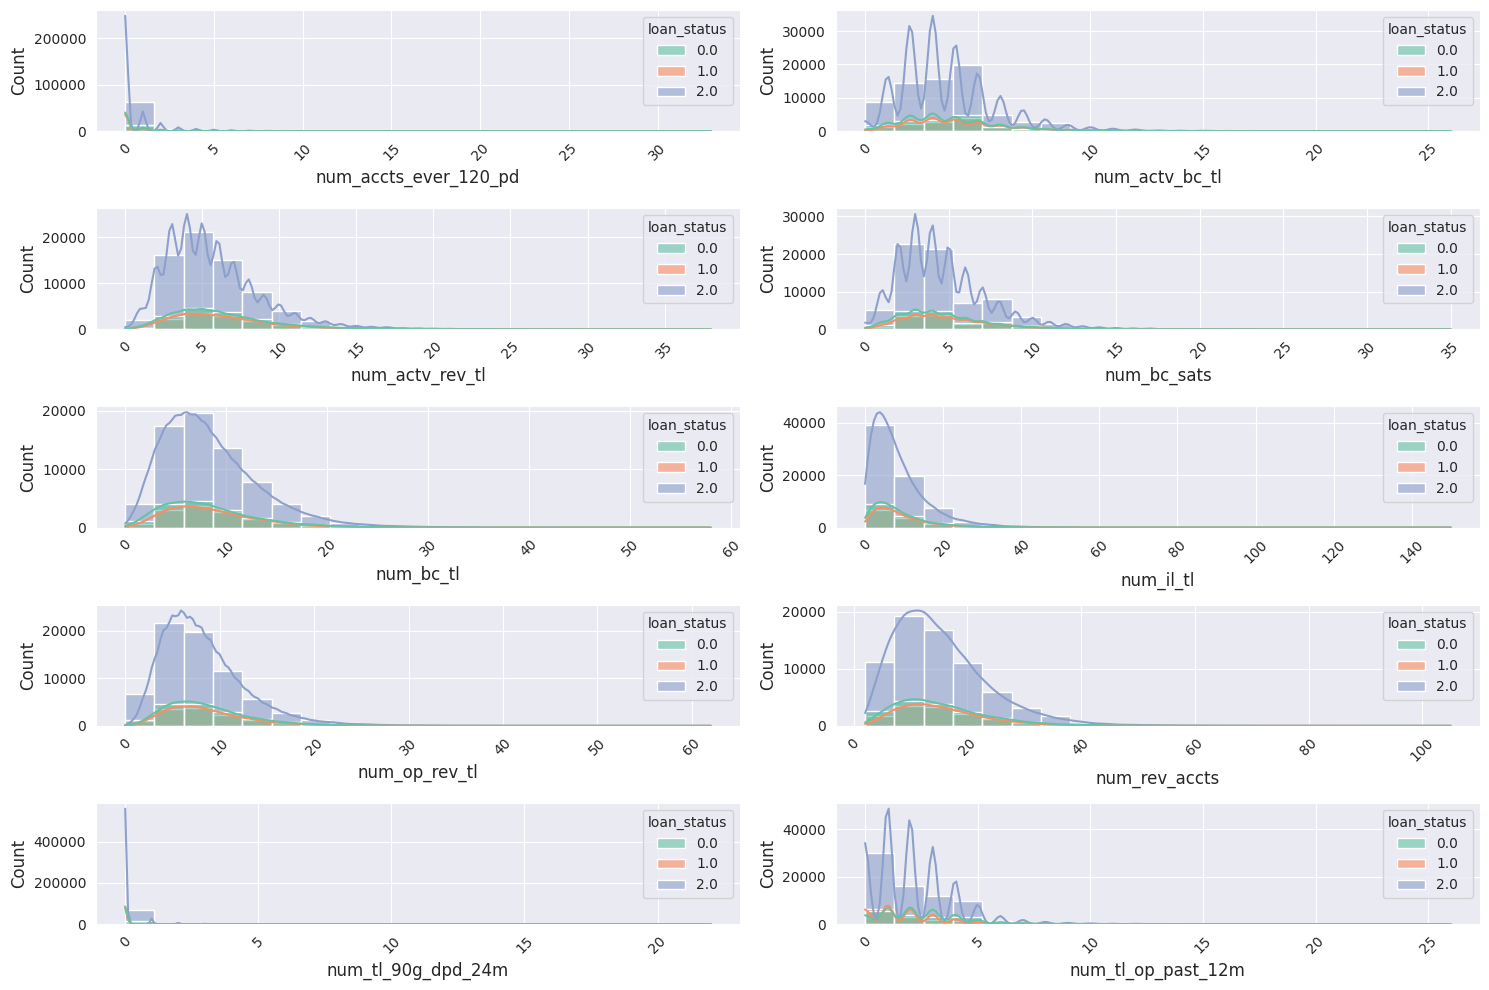

<Figure size 1500x800 with 0 Axes>

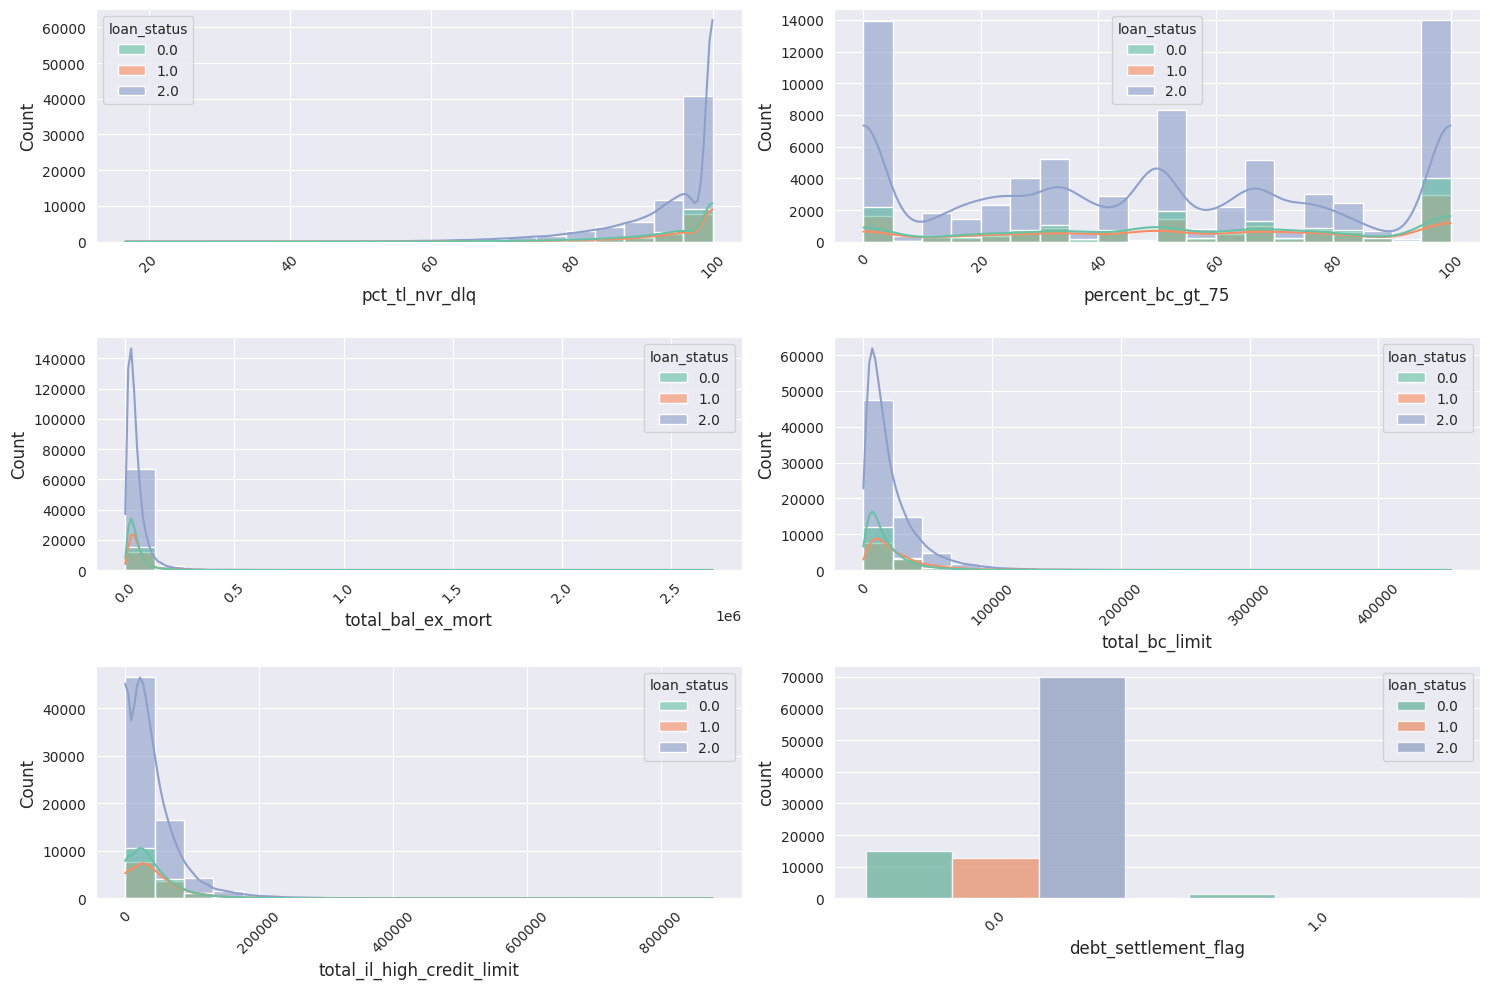

<Figure size 1500x800 with 0 Axes>

In [75]:
# Assessing the Distribution

import matplotlib.pylab as pylab

params = {
    'legend.fontsize': 'medium',
    'figure.figsize': (15, 8),
    'axes.labelsize': 'large',
    'axes.titlesize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium'
}
pylab.rcParams.update(params)

# Number of columns to plot per figure (chunk size)
chunk_size = 10
num_cols = 2  # Subplots per row

# Split columns into chunks of `chunk_size`
columns = Loan_Data_F.drop('loan_status', axis=1).columns
chunks = [columns[i:i + chunk_size] for i in range(0, len(columns), chunk_size)]

# Loop over each chunk and generate a figure for each
for i, chunk in enumerate(chunks):
    plt.figure(figsize=(15, 10))
    num_rows = int(np.ceil(len(chunk) / num_cols))  # Calculate number of rows for this chunk

    for index, col in enumerate(chunk):
        plt.subplot(num_rows, num_cols, index + 1)

        if Loan_Data_F[col].dtype == 'object' or len(Loan_Data_F[col].unique()) < 20:  # Categorical data
            sns.countplot(data=Loan_Data_F, x=col, hue='loan_status', palette="Set2", alpha=0.8)
        else:  # Continuous data
            sns.histplot(Loan_Data_F, x=col, hue='loan_status', bins=20, kde=True, palette="Set2", alpha=0.6)

        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    plt.tight_layout()
    plt.show()
    plt.savefig(f'chunk_{i}.png')  # Save each figure as a separate file

<Figure size 1500x800 with 0 Axes>

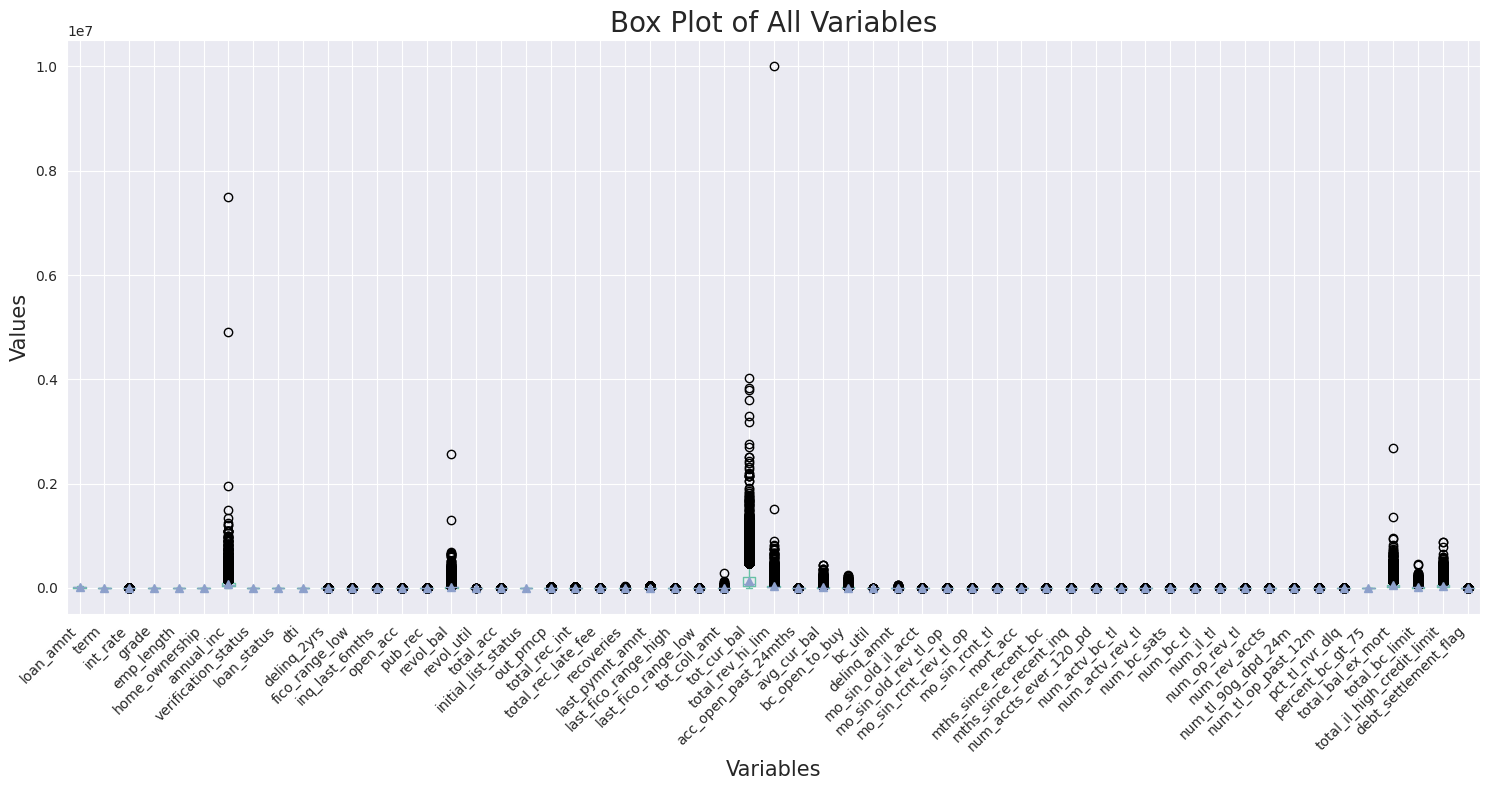

In [76]:
# Box Plot

plt.figure(figsize=(15, 8))

# Box plot for all numerical variables in the DataFrame

Loan_Data_F.plot(kind='box', showmeans=True)

# Titles and labels
plt.title('Box Plot of All Variables', fontsize=20)
plt.ylabel('Values', fontsize=15)
plt.xlabel('Variables', fontsize=15)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

In [77]:
Loan_Data_F2 = Loan_Data_F.copy()
Loan_Data_F2

loan_amnt  term  int_rate  grade  emp_length  home_ownership  \
0        15000.0   1.0     12.39    2.0        10.0             2.0   
1        10400.0   0.0      6.99    0.0         8.0             0.0   
2        21425.0   1.0     15.59    3.0         6.0             2.0   
3        12800.0   1.0     17.14    3.0        10.0             0.0   
4         7650.0   0.0     13.66    2.0         0.5             2.0   
...          ...   ...       ...    ...         ...             ...   
98858     8400.0   0.0      9.17    1.0         2.0             0.0   
98859    10000.0   0.0     12.99    2.0         3.0             2.0   
98860    30000.0   1.0     20.99    4.0        10.0             2.0   
98861     8475.0   0.0     24.99    5.0        10.0             2.0   
98862    25000.0   0.0     10.15    1.0         3.0             1.0   

       annual_inc  verification_status  loan_status    dti  ...  \
0         78000.0                  1.0          2.0  12.03  ...   
1         58000.0                  0.0          0.0  14.92  ...   
2         63800.0                  1.0          2.0  18.49  ...   
3        125000.0                  2.0          1.0   8.31  ...   
4         50000.0                  1.0          0.0  34.81  ...   
...           ...                  ...          ...    ...  ...   
98858     91000.0                  1.0          2.0   7.78  ...   
98859     53133.0                  0.0          2.0  15.25  ...   
98860     78000.0                  2.0          1.0  23.75  ...   
98861     52000.0                  2.0          0.0  17.61  ...   
98862     60000.0                  1.0          2.0  27.82  ...   

       num_op_rev_tl  num_rev_accts  num_tl_90g_dpd_24m  num_tl_op_past_12m  \
0                5.0            9.0                 0.0                 4.0   
1               14.0           32.0                 0.0                 4.0   
2                5.0           18.0                 0.0                 2.0   
3                5.0            7.0                 0.0                 0.0   
4                4.0            8.0                 0.0                 2.0   
...              ...            ...                 ...                 ...   
98858            3.0            7.0                 0.0                 2.0   
98859            9.0           13.0                 0.0                 1.0   
98860           15.0           22.0                 0.0                 4.0   
98861            8.0           18.0                 1.0                 6.0   
98862           10.0           19.0                 0.0                 3.0   

       pct_tl_nvr_dlq  percent_bc_gt_75  total_bal_ex_mort  total_bc_limit  \
0               100.0               0.0           149140.0         10000.0   
1                83.3              14.3            15030.0         13000.0   
2                91.4             100.0            42315.0         15000.0   
3                76.9             100.0            18007.0          4400.0   
4               100.0             100.0            64426.0          4900.0   
...               ...               ...                ...             ...   
98858            93.7              50.0            20872.0         11000.0   
98859           100.0              11.1            46413.0         24300.0   
98860            93.3             100.0            45447.0         22300.0   
98861            86.4             100.0            31247.0          2700.0   
98862           100.0              40.0            71301.0         40300.0   

       total_il_high_credit_limit  debt_settlement_flag  
0                         12000.0                   0.0  
1                         11325.0                   0.0  
2                         35573.0                   0.0  
3                         18000.0                   0.0  
4                         64031.0                   0.0  
...                           ...                   ...  
98858                     15473.0                   0.0  

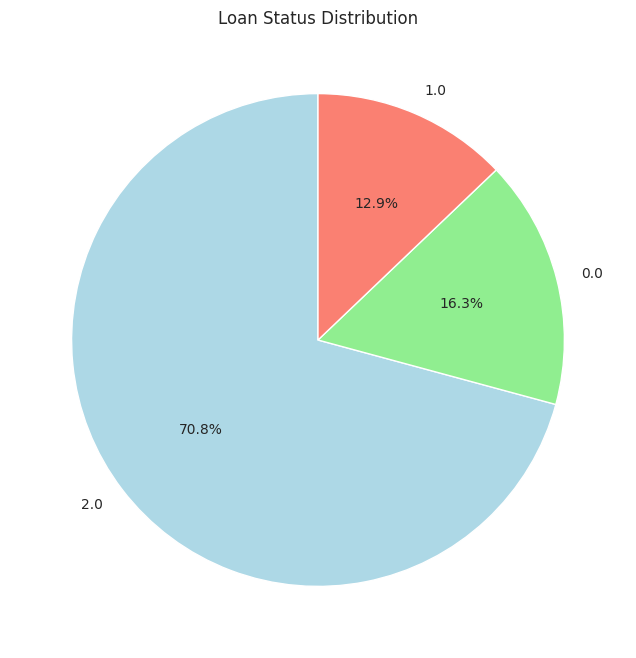

In [78]:
# Proportion of target class (loan_status) in Pie Chat

Loan_Data_F2['loan_status'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',  # Format to display percentage
    startangle=90,      # Start the pie chart at a specific angle
    colors=['lightblue', 'lightgreen', 'salmon', 'lightcoral']
)

plt.title('Loan Status Distribution')
plt.ylabel('')  # Remove y-label for a cleaner look
plt.show()

## Outlier Detection and Removal

In [79]:
# Fill outliers with inter-quatile range (Use it on loan amount & annual income only)

q1 = Loan_Data_F2[['loan_amnt', 'annual_inc']].quantile(0.25)
q3 = Loan_Data_F2[['loan_amnt', 'annual_inc']].quantile(0.75)
iqr = q3 - q1

# Lower and Upper bound for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter data for loan_amnt and annual_inc to remove outliers

Loan_Data_F2 = Loan_Data_F2[(Loan_Data_F2['loan_amnt'] >= lower_bound['loan_amnt']) & (Loan_Data_F2['loan_amnt'] <= upper_bound['loan_amnt'])]
Loan_Data_F2 = Loan_Data_F2[(Loan_Data_F2['annual_inc'] >= lower_bound['annual_inc']) & (Loan_Data_F2['annual_inc'] <= upper_bound['annual_inc'])]

Loan_Data_F2

loan_amnt  term  int_rate  grade  emp_length  home_ownership  \
0        15000.0   1.0     12.39    2.0        10.0             2.0   
1        10400.0   0.0      6.99    0.0         8.0             0.0   
2        21425.0   1.0     15.59    3.0         6.0             2.0   
3        12800.0   1.0     17.14    3.0        10.0             0.0   
4         7650.0   0.0     13.66    2.0         0.5             2.0   
...          ...   ...       ...    ...         ...             ...   
98858     8400.0   0.0      9.17    1.0         2.0             0.0   
98859    10000.0   0.0     12.99    2.0         3.0             2.0   
98860    30000.0   1.0     20.99    4.0        10.0             2.0   
98861     8475.0   0.0     24.99    5.0        10.0             2.0   
98862    25000.0   0.0     10.15    1.0         3.0             1.0   

       annual_inc  verification_status  loan_status    dti  ...  \
0         78000.0                  1.0          2.0  12.03  ...   
1         58000.0                  0.0          0.0  14.92  ...   
2         63800.0                  1.0          2.0  18.49  ...   
3        125000.0                  2.0          1.0   8.31  ...   
4         50000.0                  1.0          0.0  34.81  ...   
...           ...                  ...          ...    ...  ...   
98858     91000.0                  1.0          2.0   7.78  ...   
98859     53133.0                  0.0          2.0  15.25  ...   
98860     78000.0                  2.0          1.0  23.75  ...   
98861     52000.0                  2.0          0.0  17.61  ...   
98862     60000.0                  1.0          2.0  27.82  ...   

       num_op_rev_tl  num_rev_accts  num_tl_90g_dpd_24m  num_tl_op_past_12m  \
0                5.0            9.0                 0.0                 4.0   
1               14.0           32.0                 0.0                 4.0   
2                5.0           18.0                 0.0                 2.0   
3                5.0            7.0                 0.0                 0.0   
4                4.0            8.0                 0.0                 2.0   
...              ...            ...                 ...                 ...   
98858            3.0            7.0                 0.0                 2.0   
98859            9.0           13.0                 0.0                 1.0   
98860           15.0           22.0                 0.0                 4.0   
98861            8.0           18.0                 1.0                 6.0   
98862           10.0           19.0                 0.0                 3.0   

       pct_tl_nvr_dlq  percent_bc_gt_75  total_bal_ex_mort  total_bc_limit  \
0               100.0               0.0           149140.0         10000.0   
1                83.3              14.3            15030.0         13000.0   
2                91.4             100.0            42315.0         15000.0   
3                76.9             100.0            18007.0          4400.0   
4               100.0             100.0            64426.0          4900.0   
...               ...               ...                ...             ...   
98858            93.7              50.0            20872.0         11000.0   
98859           100.0              11.1            46413.0         24300.0   
98860            93.3             100.0            45447.0         22300.0   
98861            86.4             100.0            31247.0          2700.0   
98862           100.0              40.0            71301.0         40300.0   

       total_il_high_credit_limit  debt_settlement_flag  
0                         12000.0                   0.0  
1                         11325.0                   0.0  
2                         35573.0                   0.0  
3                         18000.0                   0.0  
4                         64031.0                   0.0  
...                           ...                   ...  
98858                     15473.0                   0.0  

## **Outlier Detection due to it effect on class balance**

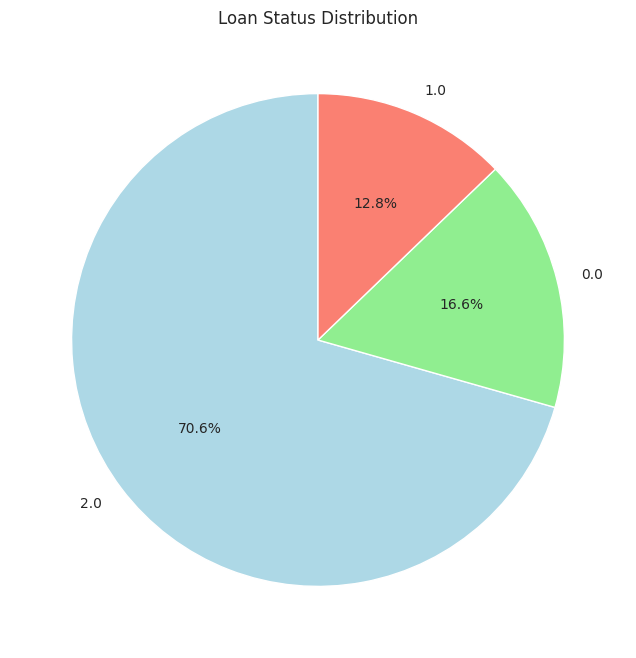

In [80]:
# Proportion of target class (loan_status) in Bar Chat

Loan_Data_F2['loan_status'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',  # Format to display percentage
    startangle=90,      # Start the pie chart at a specific angle
    colors=['lightblue', 'lightgreen', 'salmon', 'lightcoral']
)

plt.title('Loan Status Distribution')
plt.ylabel('')  # Remove y-label for a cleaner look
plt.show()

In [81]:
Loan_Data_F2.shape

(94424, 57)

In [82]:
Loan_Data_F2['loan_status'].value_counts()

loan_status
2.0    66652
0.0    15688
1.0    12084
Name: count, dtype: int64

In [83]:
# Save to CSV and download

Loan_Data_F2.to_csv('Loan_Data_F2.csv', index=False)

from google.colab import files
files.download('Loan_Data_F2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Check Unique Values to Ensure Data Quality

In [84]:
# Check Uniques Values

for col in Loan_Data_F2.columns:
    unique_values = Loan_Data_F2[col].unique()
    print(f"Unique values for {col}: {unique_values}")
    print()

Unique values for loan_amnt: [15000. 10400. 21425. ... 30975. 29875. 30475.]

Unique values for term: [1. 0.]

Unique values for int_rate: [12.39  6.99 15.59 17.14 13.66 11.99 11.44 14.31 17.86 21.99 10.49 14.99
 15.99 19.99 12.99  9.49 20.99  7.49 16.49  8.67  8.19 22.99 18.54 19.24
 25.83 25.8  24.5  23.99  6.03  6.49 25.89 24.99  6.   25.99 25.57 26.06
 17.57 14.49 13.98 12.49 16.29  8.39 23.43 15.61 18.24  9.17 16.99  7.69
 10.99 20.2  19.52 13.35 10.15 22.15 11.67 18.99  7.12 24.08]

Unique values for grade: [2. 0. 3. 1. 4. 5. 6.]

Unique values for emp_length: [10.   8.   6.   0.5  2.   9.   7.   5.   3.   4.8  4.7  4.   2.7  3.2
  3.6  3.5  5.7  6.6  6.3  5.8  5.5  5.2  9.4  7.1  8.2  3.7  6.8  5.4
  6.4  4.1  2.4  1.7  6.2  7.4  7.2  8.1  3.9  4.4  7.8  2.6  8.8  8.6
  5.9  7.7  4.3  7.5  8.4  7.6  4.6  3.3  4.9  4.2  2.2  5.6  3.8  6.9
  6.5  3.4  4.5  5.3  6.1  1.8  2.9  9.2  9.8  2.5  0.8  3.1  1.4  6.7
  9.6  1.5  1.6  5.1  2.8  2.1  7.3  1.9  2.3  7.9  1.1  1.2  1.3  1. ]


## Columns with only 1 unique value and their unique values

In [85]:
single_value_cols = [col for col in Loan_Data_F2.columns if Loan_Data_F2[col].nunique() == 1]

for col in single_value_cols:
    print(f"Column: {col}, Unique Value: {Loan_Data_F2[col].unique()[0]}")

single_value_cols_info = {col: Loan_Data_F2[col].unique()[0] for col in single_value_cols}

print("\nColumns with single unique value:")
print(single_value_cols_info)


Columns with single unique value:
{}


In [86]:
# Drop the columns

Loan_Data_F2 = Loan_Data_F2.drop(single_value_cols, axis=1)

print("\nUpdated Dataframe after dropping columns with single unique values:")
Loan_Data_F2


Updated Dataframe after dropping columns with single unique values:


loan_amnt  term  int_rate  grade  emp_length  home_ownership  \
0        15000.0   1.0     12.39    2.0        10.0             2.0   
1        10400.0   0.0      6.99    0.0         8.0             0.0   
2        21425.0   1.0     15.59    3.0         6.0             2.0   
3        12800.0   1.0     17.14    3.0        10.0             0.0   
4         7650.0   0.0     13.66    2.0         0.5             2.0   
...          ...   ...       ...    ...         ...             ...   
98858     8400.0   0.0      9.17    1.0         2.0             0.0   
98859    10000.0   0.0     12.99    2.0         3.0             2.0   
98860    30000.0   1.0     20.99    4.0        10.0             2.0   
98861     8475.0   0.0     24.99    5.0        10.0             2.0   
98862    25000.0   0.0     10.15    1.0         3.0             1.0   

       annual_inc  verification_status  loan_status    dti  ...  \
0         78000.0                  1.0          2.0  12.03  ...   
1         58000.0                  0.0          0.0  14.92  ...   
2         63800.0                  1.0          2.0  18.49  ...   
3        125000.0                  2.0          1.0   8.31  ...   
4         50000.0                  1.0          0.0  34.81  ...   
...           ...                  ...          ...    ...  ...   
98858     91000.0                  1.0          2.0   7.78  ...   
98859     53133.0                  0.0          2.0  15.25  ...   
98860     78000.0                  2.0          1.0  23.75  ...   
98861     52000.0                  2.0          0.0  17.61  ...   
98862     60000.0                  1.0          2.0  27.82  ...   

       num_op_rev_tl  num_rev_accts  num_tl_90g_dpd_24m  num_tl_op_past_12m  \
0                5.0            9.0                 0.0                 4.0   
1               14.0           32.0                 0.0                 4.0   
2                5.0           18.0                 0.0                 2.0   
3                5.0            7.0                 0.0                 0.0   
4                4.0            8.0                 0.0                 2.0   
...              ...            ...                 ...                 ...   
98858            3.0            7.0                 0.0                 2.0   
98859            9.0           13.0                 0.0                 1.0   
98860           15.0           22.0                 0.0                 4.0   
98861            8.0           18.0                 1.0                 6.0   
98862           10.0           19.0                 0.0                 3.0   

       pct_tl_nvr_dlq  percent_bc_gt_75  total_bal_ex_mort  total_bc_limit  \
0               100.0               0.0           149140.0         10000.0   
1                83.3              14.3            15030.0         13000.0   
2                91.4             100.0            42315.0         15000.0   
3                76.9             100.0            18007.0          4400.0   
4               100.0             100.0            64426.0          4900.0   
...               ...               ...                ...             ...   
98858            93.7              50.0            20872.0         11000.0   
98859           100.0              11.1            46413.0         24300.0   
98860            93.3             100.0            45447.0         22300.0   
98861            86.4             100.0            31247.0          2700.0   
98862           100.0              40.0            71301.0         40300.0   

       total_il_high_credit_limit  debt_settlement_flag  
0                         12000.0                   0.0  
1                         11325.0                   0.0  
2                         35573.0                   0.0  
3                         18000.0                   0.0  
4                         64031.0                   0.0  
...                           ...                   ...  
98858                     15473.0                   0.0  

## Model Building

In [87]:
Loan_Data_F2

loan_amnt  term  int_rate  grade  emp_length  home_ownership  \
0        15000.0   1.0     12.39    2.0        10.0             2.0   
1        10400.0   0.0      6.99    0.0         8.0             0.0   
2        21425.0   1.0     15.59    3.0         6.0             2.0   
3        12800.0   1.0     17.14    3.0        10.0             0.0   
4         7650.0   0.0     13.66    2.0         0.5             2.0   
...          ...   ...       ...    ...         ...             ...   
98858     8400.0   0.0      9.17    1.0         2.0             0.0   
98859    10000.0   0.0     12.99    2.0         3.0             2.0   
98860    30000.0   1.0     20.99    4.0        10.0             2.0   
98861     8475.0   0.0     24.99    5.0        10.0             2.0   
98862    25000.0   0.0     10.15    1.0         3.0             1.0   

       annual_inc  verification_status  loan_status    dti  ...  \
0         78000.0                  1.0          2.0  12.03  ...   
1         58000.0                  0.0          0.0  14.92  ...   
2         63800.0                  1.0          2.0  18.49  ...   
3        125000.0                  2.0          1.0   8.31  ...   
4         50000.0                  1.0          0.0  34.81  ...   
...           ...                  ...          ...    ...  ...   
98858     91000.0                  1.0          2.0   7.78  ...   
98859     53133.0                  0.0          2.0  15.25  ...   
98860     78000.0                  2.0          1.0  23.75  ...   
98861     52000.0                  2.0          0.0  17.61  ...   
98862     60000.0                  1.0          2.0  27.82  ...   

       num_op_rev_tl  num_rev_accts  num_tl_90g_dpd_24m  num_tl_op_past_12m  \
0                5.0            9.0                 0.0                 4.0   
1               14.0           32.0                 0.0                 4.0   
2                5.0           18.0                 0.0                 2.0   
3                5.0            7.0                 0.0                 0.0   
4                4.0            8.0                 0.0                 2.0   
...              ...            ...                 ...                 ...   
98858            3.0            7.0                 0.0                 2.0   
98859            9.0           13.0                 0.0                 1.0   
98860           15.0           22.0                 0.0                 4.0   
98861            8.0           18.0                 1.0                 6.0   
98862           10.0           19.0                 0.0                 3.0   

       pct_tl_nvr_dlq  percent_bc_gt_75  total_bal_ex_mort  total_bc_limit  \
0               100.0               0.0           149140.0         10000.0   
1                83.3              14.3            15030.0         13000.0   
2                91.4             100.0            42315.0         15000.0   
3                76.9             100.0            18007.0          4400.0   
4               100.0             100.0            64426.0          4900.0   
...               ...               ...                ...             ...   
98858            93.7              50.0            20872.0         11000.0   
98859           100.0              11.1            46413.0         24300.0   
98860            93.3             100.0            45447.0         22300.0   
98861            86.4             100.0            31247.0          2700.0   
98862           100.0              40.0            71301.0         40300.0   

       total_il_high_credit_limit  debt_settlement_flag  
0                         12000.0                   0.0  
1                         11325.0                   0.0  
2                         35573.0                   0.0  
3                         18000.0                   0.0  
4                         64031.0                   0.0  
...                           ...                   ...  
98858                     15473.0                   0.0  

In [88]:
input = Loan_Data_F2.drop(['loan_status'], axis=1)
target = Loan_Data_F2['loan_status']

In [89]:
target

0        2.0
1        0.0
2        2.0
3        1.0
4        0.0
        ... 
98858    2.0
98859    2.0
98860    1.0
98861    0.0
98862    2.0
Name: loan_status, Length: 94424, dtype: float64

In [90]:
input

loan_amnt  term  int_rate  grade  emp_length  home_ownership  \
0        15000.0   1.0     12.39    2.0        10.0             2.0   
1        10400.0   0.0      6.99    0.0         8.0             0.0   
2        21425.0   1.0     15.59    3.0         6.0             2.0   
3        12800.0   1.0     17.14    3.0        10.0             0.0   
4         7650.0   0.0     13.66    2.0         0.5             2.0   
...          ...   ...       ...    ...         ...             ...   
98858     8400.0   0.0      9.17    1.0         2.0             0.0   
98859    10000.0   0.0     12.99    2.0         3.0             2.0   
98860    30000.0   1.0     20.99    4.0        10.0             2.0   
98861     8475.0   0.0     24.99    5.0        10.0             2.0   
98862    25000.0   0.0     10.15    1.0         3.0             1.0   

       annual_inc  verification_status    dti  delinq_2yrs  ...  \
0         78000.0                  1.0  12.03          0.0  ...   
1         58000.0                  0.0  14.92          0.0  ...   
2         63800.0                  1.0  18.49          0.0  ...   
3        125000.0                  2.0   8.31          1.0  ...   
4         50000.0                  1.0  34.81          0.0  ...   
...           ...                  ...    ...          ...  ...   
98858     91000.0                  1.0   7.78          1.0  ...   
98859     53133.0                  0.0  15.25          0.0  ...   
98860     78000.0                  2.0  23.75          0.0  ...   
98861     52000.0                  2.0  17.61          2.0  ...   
98862     60000.0                  1.0  27.82          0.0  ...   

       num_op_rev_tl  num_rev_accts  num_tl_90g_dpd_24m  num_tl_op_past_12m  \
0                5.0            9.0                 0.0                 4.0   
1               14.0           32.0                 0.0                 4.0   
2                5.0           18.0                 0.0                 2.0   
3                5.0            7.0                 0.0                 0.0   
4                4.0            8.0                 0.0                 2.0   
...              ...            ...                 ...                 ...   
98858            3.0            7.0                 0.0                 2.0   
98859            9.0           13.0                 0.0                 1.0   
98860           15.0           22.0                 0.0                 4.0   
98861            8.0           18.0                 1.0                 6.0   
98862           10.0           19.0                 0.0                 3.0   

       pct_tl_nvr_dlq  percent_bc_gt_75  total_bal_ex_mort  total_bc_limit  \
0               100.0               0.0           149140.0         10000.0   
1                83.3              14.3            15030.0         13000.0   
2                91.4             100.0            42315.0         15000.0   
3                76.9             100.0            18007.0          4400.0   
4               100.0             100.0            64426.0          4900.0   
...               ...               ...                ...             ...   
98858            93.7              50.0            20872.0         11000.0   
98859           100.0              11.1            46413.0         24300.0   
98860            93.3             100.0            45447.0         22300.0   
98861            86.4             100.0            31247.0          2700.0   
98862           100.0              40.0            71301.0         40300.0   

       total_il_high_credit_limit  debt_settlement_flag  
0                         12000.0                   0.0  
1                         11325.0                   0.0  
2                         35573.0                   0.0  
3                         18000.0                   0.0  
4                         64031.0                   0.0  
...                           ...                   ...  
98858                     15473.0                   0.0  

In [91]:
# Splitting into train and test sets with stratify

from sklearn.model_selection import train_test_split

y = target
X = input

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [92]:
#@title Create and Train Decision Tree classifier object

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset

y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n")
print("\033[1;35;40mDecision Tree Classifier \033[0m")


#Generate confusion matrix for our results
results = metrics.confusion_matrix(y_test,y_pred)
print("\nConfusion Matrix:\n",results)
#Evaluating model accuracy
print("\nAccuracy:\n", metrics.classification_report(y_test,y_pred))

Accuracy: 0.9705586444267937


Decision Tree Classifier 

Confusion Matrix:
 [[ 2875     0   263]
 [    0  2416     1]
 [  289     3 13038]]

Accuracy:
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      3138
         1.0       1.00      1.00      1.00      2417
         2.0       0.98      0.98      0.98     13330

    accuracy                           0.97     18885
   macro avg       0.96      0.96      0.96     18885
weighted avg       0.97      0.97      0.97     18885



In [93]:
# Feauture importance and decision tree
#print(tree.plot_tree(clf))

from sklearn.tree import plot_tree

[Text(0.6335646196644711, 0.9871794871794872, 'out_prncp <= 0.01\ngini = 0.458\nsamples = 75539\nvalue = [12550.0, 9667.0, 53322.0]\nclass = fully paid'),
 Text(0.632480157223316, 0.9615384615384616, 'recoveries <= 5.0\ngini = 0.309\nsamples = 65881\nvalue = [12550, 9, 53322]\nclass = fully paid'),
 Text(0.6330223884438935, 0.9743589743589745, 'True  '),
 Text(0.6313956947821608, 0.9358974358974359, 'last_fico_range_low <= 612.5\ngini = 0.147\nsamples = 57941\nvalue = [4610, 9, 53322]\nclass = fully paid'),
 Text(0.4485438490447345, 0.9102564102564102, 'last_pymnt_amnt <= 1301.265\ngini = 0.493\nsamples = 8181\nvalue = [3578, 4, 4599]\nclass = fully paid'),
 Text(0.3403687370870931, 0.8846153846153846, 'term <= 0.5\ngini = 0.475\nsamples = 5802\nvalue = [3557, 4, 2241]\nclass = charged-off'),
 Text(0.14810967685481535, 0.8589743589743589, 'last_fico_range_high <= 541.5\ngini = 0.5\nsamples = 4245\nvalue = [2036, 4, 2205]\nclass = fully paid'),
 Text(0.051332987290264344, 0.833333333333

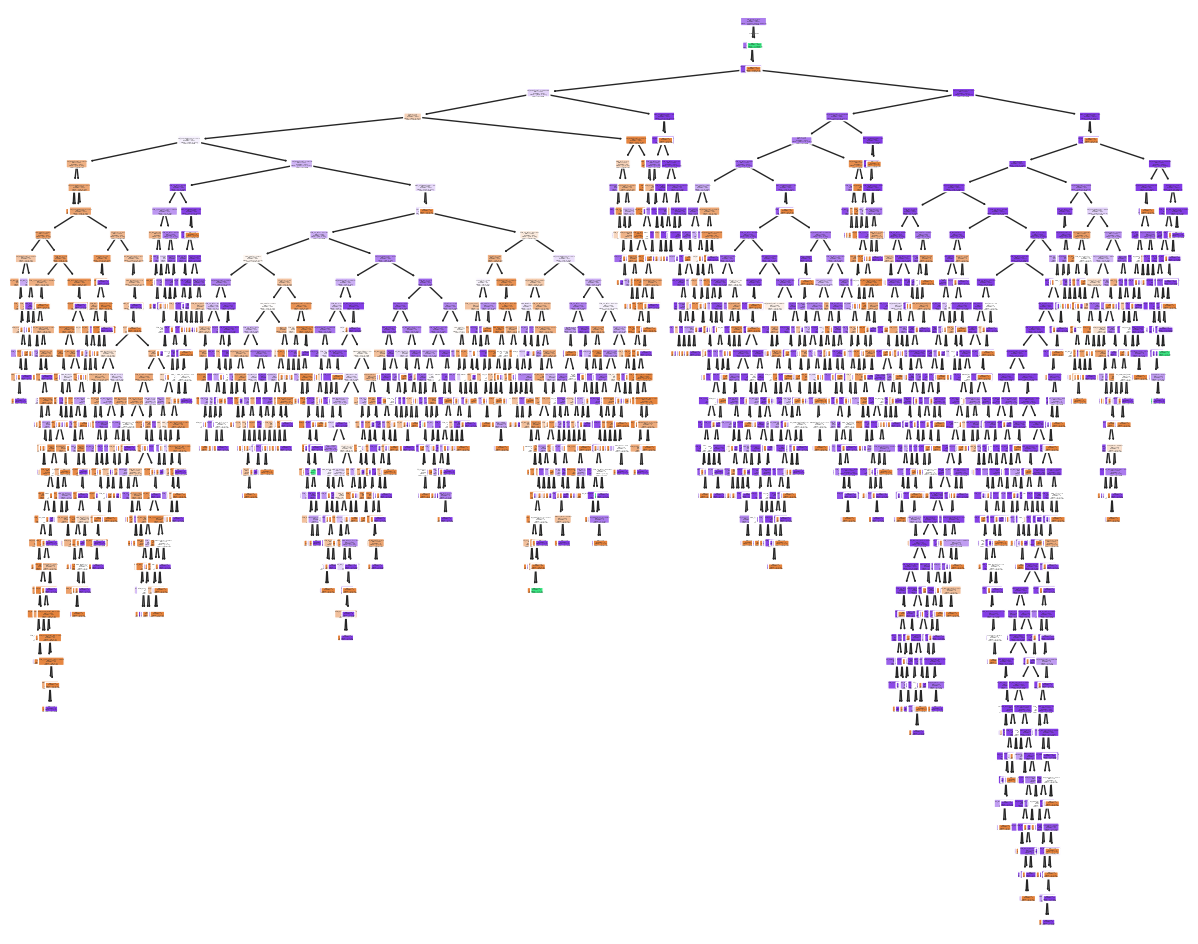

In [94]:
clf = DecisionTreeClassifier()

# training the model
clf = clf.fit(X_train, y_train)

plt.figure(figsize=(15, 12))
plot_tree(clf,
          filled=True,
          rounded=True,
          class_names=["charged-off", "current", "fully paid"],
          feature_names=X.columns)

out_prncp: 0.4120
recoveries: 0.3421
last_fico_range_low: 0.0725
last_pymnt_amnt: 0.0551
term: 0.0281
last_fico_range_high: 0.0129
total_rec_int: 0.0108
loan_amnt: 0.0104
int_rate: 0.0053
debt_settlement_flag: 0.0032
mo_sin_old_rev_tl_op: 0.0026
dti: 0.0022
total_bc_limit: 0.0020
total_acc: 0.0019
mths_since_recent_inq: 0.0018
revol_bal: 0.0018
avg_cur_bal: 0.0018
total_rev_hi_lim: 0.0016
num_op_rev_tl: 0.0016
mo_sin_old_il_acct: 0.0015
annual_inc: 0.0015
total_il_high_credit_limit: 0.0015
revol_util: 0.0015
num_bc_tl: 0.0015
bc_open_to_buy: 0.0014
mths_since_recent_bc: 0.0014
fico_range_low: 0.0014
bc_util: 0.0013
total_bal_ex_mort: 0.0011
acc_open_past_24mths: 0.0011
pct_tl_nvr_dlq: 0.0011
tot_cur_bal: 0.0011
open_acc: 0.0010
num_rev_accts: 0.0009
grade: 0.0009
num_actv_rev_tl: 0.0008
mo_sin_rcnt_tl: 0.0008
num_accts_ever_120_pd: 0.0008
mort_acc: 0.0007
percent_bc_gt_75: 0.0007
mo_sin_rcnt_rev_tl_op: 0.0006
emp_length: 0.0006
num_il_tl: 0.0006
verification_status: 0.0006
inq_last_6mt

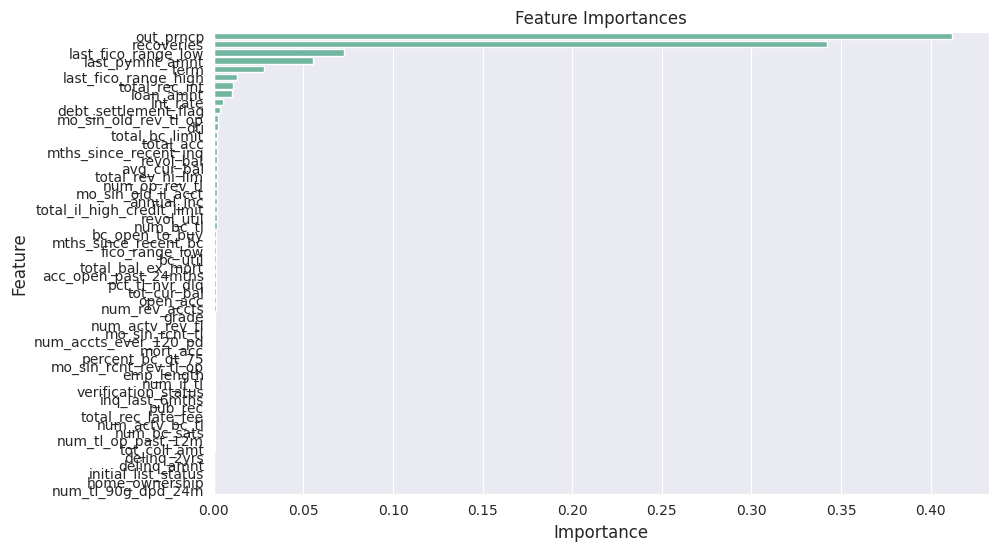

In [95]:
# Plotting the feature importance of the decision tree

importances = clf.feature_importances_

# Sort the features by importance in descending order (Highest to Lowest)

features = sorted(zip(importances, X.columns), reverse=True)

# Print the features and their importance scores

for importance, feature in features:
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=[importance for importance, _ in features], y=[feature for _, feature in features])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [96]:
#@title Naive bayes
model = GaussianNB()

#Train the model using the training sets
model=model.fit(X_train, y_train)

#Predict Output
y_pred = model.predict(X_test)

print("\n")
print("\033[1;32;40mNaive Bayesian Classifier \033[0m")

#Generate confusion matrix for our results
results2 = metrics.confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", results2)

#Evaluating model accuracy
print("\nAccuracy:\n", metrics.classification_report(y_test,y_pred))



Naive Bayesian Classifier 

Confusion Matrix:
 [[ 2592    18   528]
 [    9  2373    35]
 [  274    52 13004]]

Accuracy:
               precision    recall  f1-score   support

         0.0       0.90      0.83      0.86      3138
         1.0       0.97      0.98      0.98      2417
         2.0       0.96      0.98      0.97     13330

    accuracy                           0.95     18885
   macro avg       0.94      0.93      0.94     18885
weighted avg       0.95      0.95      0.95     18885



In [97]:
#@title Multinomial Approach

from sklearn.naive_bayes import MultinomialNB

In [98]:
MNBmodel =  MultinomialNB()
MNBmodel =MNBmodel.fit(X_train, y_train)
y_pred = MNBmodel.predict(X_test)

print("\n")
print("\033[1;33;40mMultiNominal Naive Bayes Classifier \033[0m")

#Generate confusion matrix for our results
results3 = metrics.confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", results3)

#Evaluating model accuracy
print("\nAccuracy:\n", metrics.classification_report(y_test,y_pred))



MultiNominal Naive Bayes Classifier 

Confusion Matrix:
 [[2731   60  347]
 [  50 2351   16]
 [4299  114 8917]]

Accuracy:
               precision    recall  f1-score   support

         0.0       0.39      0.87      0.53      3138
         1.0       0.93      0.97      0.95      2417
         2.0       0.96      0.67      0.79     13330

    accuracy                           0.74     18885
   macro avg       0.76      0.84      0.76     18885
weighted avg       0.86      0.74      0.77     18885



In [99]:
#@title Random Forrest classifier
# instantiate the model

RFmodel = RandomForestClassifier(n_estimators=10)

# fit the model
RFmodel = RFmodel.fit(X_train,y_train)

y_pred = RFmodel.predict(X_test)

print("\n")
print("\033[1;34;40m Random Forrest Classifier \033[0m")

#Generate confusion matrix for our results
results5 = metrics.confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", results5)

#Evaluating model accuracy
print("\nAccuracy:\n", metrics.classification_report(y_test,y_pred))



 Random Forrest Classifier 

Confusion Matrix:
 [[ 2863     0   275]
 [    2  2415     0]
 [  231     0 13099]]

Accuracy:
               precision    recall  f1-score   support

         0.0       0.92      0.91      0.92      3138
         1.0       1.00      1.00      1.00      2417
         2.0       0.98      0.98      0.98     13330

    accuracy                           0.97     18885
   macro avg       0.97      0.96      0.97     18885
weighted avg       0.97      0.97      0.97     18885



In [100]:
#@title Logestic Regression Classifier

from sklearn.linear_model import LogisticRegression

# instantiate the model
log = LogisticRegression()

# fit the model
log.fit(X_train,y_train)

y_pred = log.predict(X_test)

print("\n")
print("\033[1;35;40m Logistic Regression Classifier \033[0m")

#Generate confusion matrix for our results
results6 = metrics.confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", results6)

#Evaluating model accuracy
print("\nAccuracy:\n", metrics.classification_report(y_test,y_pred))



 Logistic Regression Classifier 

Confusion Matrix:
 [[ 1694    24  1420]
 [   10  2336    71]
 [  398     4 12928]]

Accuracy:
               precision    recall  f1-score   support

         0.0       0.81      0.54      0.65      3138
         1.0       0.99      0.97      0.98      2417
         2.0       0.90      0.97      0.93     13330

    accuracy                           0.90     18885
   macro avg       0.90      0.83      0.85     18885
weighted avg       0.89      0.90      0.89     18885



In [101]:
# Lasso Regression

from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
lasso_preds = lasso_model.predict(X_test)

In [102]:
# import mean square error and R^2

from sklearn.metrics import mean_squared_error, r2_score

In [103]:
# Evaluate the model

y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.23138723745008552
R-squared: 0.6015731640675783


In [104]:
# XG-Boost

from xgboost import XGBClassifier

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluate the XGBoost model
xgb_accuracy_stratified = accuracy_score(y_test, xgb_preds)

# Classification report for XGBoost
xgb_report_stratified = classification_report(y_test, xgb_preds, target_names=["charged-off", "current", "fully paid"])

# Confusion matrix for XGBoost
xgb_confusion_matrix_stratified = confusion_matrix(y_test, xgb_preds)

# Display the report
import pandas as pd
report_df = pd.DataFrame(xgb_report_stratified.splitlines())
print(report_df)

                                                   0
0                precision    recall  f1-score   ...
1                                                   
2   charged-off       0.97      0.94      0.96   ...
3       current       1.00      1.00      1.00   ...
4    fully paid       0.99      0.99      0.99   ...
5                                                   
6      accuracy                           0.98   ...
7     macro avg       0.98      0.98      0.98   ...
8  weighted avg       0.98      0.98      0.98   ...


In [105]:
#@title Confusion Matrix

results7 = metrics.confusion_matrix(y_test, xgb_preds)
print("\nConfusion Matrix:\n", results7)

#Evaluating model accuracy
print("\nAccuracy:\n", metrics.classification_report(y_test,xgb_preds))


Confusion Matrix:
 [[ 2963     0   175]
 [    2  2405    10]
 [   97     0 13233]]

Accuracy:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.96      3138
         1.0       1.00      1.00      1.00      2417
         2.0       0.99      0.99      0.99     13330

    accuracy                           0.98     18885
   macro avg       0.98      0.98      0.98     18885
weighted avg       0.98      0.98      0.98     18885



In [107]:
!pip install keras
!pip install tensorflow

In [109]:
#@title Deep Neural Network

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [110]:
# Define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 output classes (Charged Off, Current, Fully Paid)
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = tf.argmax(y_pred_probs, axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

Epoch 1/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8023 - loss: 500.8278 - val_accuracy: 0.8969 - val_loss: 194.7808
Epoch 2/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8815 - loss: 144.3002 - val_accuracy: 0.9265 - val_loss: 51.6080
Epoch 3/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8980 - loss: 77.9424 - val_accuracy: 0.8841 - val_loss: 40.7798
Epoch 4/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9071 - loss: 55.5371 - val_accuracy: 0.9237 - val_loss: 36.7286
Epoch 5/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9057 - loss: 42.8718 - val_accuracy: 0.9320 - val_loss: 18.0595
Epoch 6/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9097 - loss: 24.1129 - val_accuracy: 0.9138 - val_loss: 14.4450
Epoch 7/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9084 - loss: 15.7183 - val_accuracy: 0.9089 - val_loss: 5.6614
Epoch 8/10
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 -

# Model Improvement

In [111]:
#@title Class imbalance handling

!pip install imblearn
from imblearn.over_sampling import SMOTE

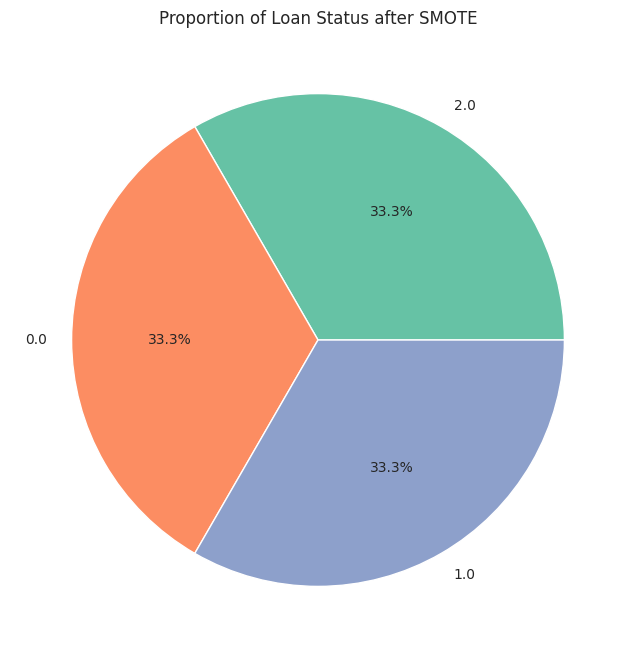

In [112]:
#@title Using SMOTE to balance the data

input = Loan_Data_F2.drop(['loan_status'], axis=1)
target = Loan_Data_F2['loan_status']

y = target
X = input

# Calculate the minimum number of samples in any class
min_class_count = y.value_counts().min()

# Create SMOTE object with k_neighbors

k_neighbors_value = min(5, min_class_count - 1)  # Using min(5, min_class_count - 1) to ensure it's at least 1 and at most 5
smote = SMOTE(random_state=42, k_neighbors=k_neighbors_value)

# Oversample the minority class
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a dataframe with the resampled data
loan_resampled_pd = pd.DataFrame(X_resampled, columns=X.columns)
loan_resampled_pd['loan_status'] = y_resampled

# Get the value counts of the "loan_status" column
loan_counts_resampled = loan_resampled_pd['loan_status'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(loan_counts_resampled, labels=loan_counts_resampled.index, autopct="%1.1f%%")
plt.title("Proportion of Loan Status after SMOTE")
plt.show()


In [113]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [114]:
# Create a DNN model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 output classes (Charged Off, Current, Fully Paid)
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = tf.argmax(y_pred_probs, axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

Epoch 1/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9385 - loss: 0.1736 - val_accuracy: 0.9730 - val_loss: 0.0782
Epoch 2/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9770 - loss: 0.0678 - val_accuracy: 0.9771 - val_loss: 0.0644
Epoch 3/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9796 - loss: 0.0585 - val_accuracy: 0.9776 - val_loss: 0.0624
Epoch 4/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9804 - loss: 0.0562 - val_accuracy: 0.9776 - val_loss: 0.0634
Epoch 5/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9819 - loss: 0.0519 - val_accuracy: 0.9805 - val_loss: 0.0568
Epoch 6/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9826 - loss: 0.0498 - val_accuracy: 0.9805 - val_loss: 0.0575
Epoch 7/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9832 - loss: 0.0464 - val_accuracy: 0.9804 - val_loss: 0.0578
Epoch 8/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9841 - loss: 0.0453 - 

In [115]:
#@title Create and Train Decision Tree classifier object

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset

y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n")
print("\033[1;35;40mDecision Tree Classifier \033[0m")

# Generate confusion matrix for our results
results = metrics.confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", results)
# Evaluating model accuracy
print("\nAccuracy:\n", metrics.classification_report(y_test, y_pred))

Accuracy: 0.9843218643728746


Decision Tree Classifier 

Confusion Matrix:
 [[13102     0   313]
 [    0 13328     2]
 [  312     0 12935]]

Accuracy:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     13415
         1.0       1.00      1.00      1.00     13330
         2.0       0.98      0.98      0.98     13247

    accuracy                           0.98     39992
   macro avg       0.98      0.98      0.98     39992
weighted avg       0.98      0.98      0.98     39992



In [116]:
##naive bayes##################
model = GaussianNB()

#Train the model using the training sets
model=model.fit(X_train, y_train)

#Predict Output
y_pred = model.predict(X_test)

print("\n")
print("\033[1;32;40mNaive Bayesian Classifier \033[0m")

#Generate confusion matrix for our results
results2 = metrics.confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", results2)

#Evaluating model accuracy
print("\nAccuracy:\n", metrics.classification_report(y_test,y_pred))



Naive Bayesian Classifier 

Confusion Matrix:
 [[11330   106  1979]
 [    0 13305    25]
 [   62    19 13166]]

Accuracy:
               precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     13415
         1.0       0.99      1.00      0.99     13330
         2.0       0.87      0.99      0.93     13247

    accuracy                           0.95     39992
   macro avg       0.95      0.95      0.94     39992
weighted avg       0.95      0.95      0.94     39992



# Project Report: Loan Default Prediction using Machine Learning

## Project Overview

This project aims to predict the loan status of borrowers based on various financial and demographic features. The goal is to build a predictive model that can accurately classify loan applications as "Charged Off," "Current," or "Fully Paid."  The project involves data preprocessing, exploratory data analysis, model building, and performance evaluation.

## Data Preprocessing

1. **Data Loading and Initial Exploration:** The project begins by loading the loan dataset and identifying numeric and non-numeric columns. The `int_rate` column is converted to float type.

2. **Handling Non-Numeric Features:** Non-numeric columns are dropped due to their complexity in this analysis, focusing only on numeric features.

3. **Missing Value Imputation:** Missing values in numeric columns are addressed using KNN imputation, a method that estimates missing values based on the values of neighboring data points.  This helps to preserve data integrity.

4. **Data Quality Check:**  The dataset is further inspected for null values and unique values for each column, ensuring data quality before the modeling process.  Columns with only one unique value are identified and removed as they do not contribute to predictive power.


## Exploratory Data Analysis (EDA)

1. **Correlation Analysis:**  Correlation analysis and a heatmap are used to visualize the relationships between numeric features and the target variable (`loan_status`).

2. **Data Distribution Visualization:** Distributions of all features are visualized using histograms and count plots for numerical and categorical features, respectively. This provides insights into the distribution of data and potential relationships with the target variable.

3. **Box Plots:** Box plots are generated for all numerical variables to visualize potential outliers and understand the distribution's central tendency and variability.

4. **Class Imbalance:** A pie chart displays the proportion of each loan status category. This step helps detect potential class imbalances which may bias model training.

5. **Outlier Treatment:** Outliers in 'loan_amnt' and 'annual_inc' are handled using the interquartile range (IQR) method, to mitigate their effects on the model's performance.  Another pie chart, shows the loan status distribution after outlier treatment to observe the impact on class balance.


## Model Building and Evaluation

Several machine learning models are employed to predict loan status:

1. **Decision Tree:**  A Decision Tree classifier is trained and evaluated using accuracy, confusion matrix, and a classification report.  Feature importances are visualized to understand which features contribute the most to prediction.  The decision tree itself is also visualized.

2. **Naive Bayes:** A Gaussian Naive Bayes model is used, with similar evaluation metrics as the decision tree model.

3. **Multinomial Naive Bayes:**  A Multinomial Naive Bayes model is also included in the analysis for comparison.

4. **Random Forest:** A Random Forest Classifier provides more robust predictions.

5. **Logistic Regression:**  A Logistic Regression model is used for predicting probabilities.

6. **Lasso Regression:** Lasso regression is used to provide a baseline.

7. **XG-Boost:** XGBoost classifier results, along with its confusion matrix and classification report, are included in the evaluation.

8. **Deep Neural Network (DNN):** A Deep Neural Network is trained and evaluated using accuracy, loss function, and classification reports. The model is improved further by handling class imbalance in the data.

9. **Model Improvement (Class Imbalance Handling):** The project demonstrates using SMOTE for handling class imbalances, retraining the DNN and Decision Tree classifier models on the balanced dataset, and then comparing the performance after SMOTE implementation.


## Results

The performance of each model is evaluated using accuracy, confusion matrices, classification reports, and other relevant metrics.  The report includes comparisons between the different models, showing the relative strengths and weaknesses of each technique.  Importantly, handling class imbalance using SMOTE improves the models' ability to correctly predict minority classes.

## Conclusion

The project successfully builds and evaluates several predictive models for loan status.  The findings provide insights into the effectiveness of different modeling techniques and the importance of data preprocessing, particularly handling class imbalances.

##**Other Models Using Pycaret**